# Data Science Interview
## David Romero Grajales
## 1032480924

El objetivo es construir un sistema para detectar automáticamente textos que contienen lenguaje ofensivo (inclusive de género, raza, etc...) o vulgar.

Para esto debes generar un modelo de clasificación utilizando un esquema basado en árboles de decisión. (Por ejemplo: Random Forest, XGBoost, LightGBM, etc...).

El proceso de desarrollo debe seguir el flujo completo de modelado en machine learning (análisis de datos, feature engineering, selección de modelo, métricas) con reporte de resultados y proceso. Toda decisión tomada dentro del pipeline debe ser agregada al reporte.

Luego de haber seleccionado el mejor modelo de clasificación, para el reporte, haz un análisis comparativo de los dos mejores modelos que hayas obtenido con la métrica que consideres se adapta mejor al problema.

ACLARACIONES
Para este ejercicio se tendrá en cuenta el proceso, flujo de modelado, análsis comparativos, selección de modelo, entendimiento de métricas por lo tanto el valor de la métrica final obtenida NO es un factor relevante a tener en cuenta

In [172]:
# Librerías estándar de Python para manipulación de datos y visualización
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from time import time

# Procesamiento de texto y NLP
import re
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Modelado y evaluación de modelos de Machine Learning
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

# Modelos de ensamble y boosting
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


In [4]:
df = pd.read_csv('data_toxic.csv')

In [5]:
pd.set_option('display.max_colwidth', None)

df.head()

message  \
0                                                                                                                                               Hola, dale actualizar a la pagina o la tecla F5   
1  Ningún mujer te va a dejar por un error. porque todos somos humanos y el algún momento la cagamos pero siempre hay la oportunidad de mejorar en la cagas que uno hace y más si te hace feliz   
2                                Entonces, si está haciendo una correspondencia en R ^ 2, ¿cómo dibujaría G (x) = {y es un elemento de R2 tal que el producto escalar de x e y es 0} si G (3,4)   
3                                                                                                                                                   victoria con el pelito corto me voy a matar   
4                                                                                                      @LoloPeniche Periodista!!!!!\nEs una puta verdulera la HDSPTM... https://t.co/6wyiTra4ko   

   label  
0      0  
1      1  
2      0  
3      1  
4      1

## Revisión general base de datos

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514555 entries, 0 to 514554
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   message  514555 non-null  object
 1   label    514555 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.9+ MB


Los datos se encuentran con correcto formato, para los mensajes es tipo objeti mientras que label es entero (binario)

In [6]:
df.count()

message    514555
label      514555
dtype: int64

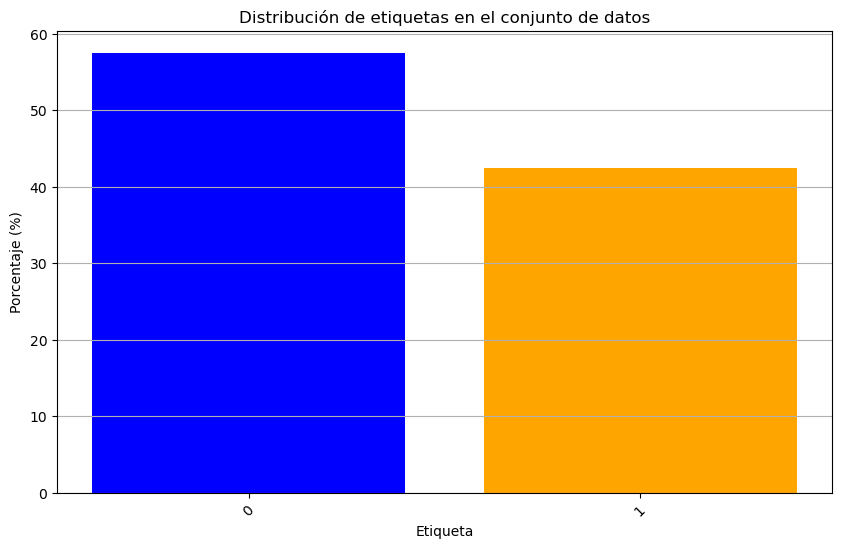

In [11]:


label_counts = df['label'].value_counts()
label_percentages = (label_counts / label_counts.sum()) * 100


plt.figure(figsize=(10, 6))
plt.bar(label_counts.index.astype(str), label_percentages, color=['blue', 'orange'])

plt.xlabel('Etiqueta')
plt.ylabel('Porcentaje (%)')
plt.title('Distribución de etiquetas en el conjunto de datos')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()

In [7]:
df.label.sum()/df.count()[0]

0.42486808990292585

Se parte de 514.555 registros, de los cuales el 42.4% son comentarios ofensivos. Es decir tenemos los datos un poco balanceados en cuanto a la predicción

In [8]:
df.isnull().sum()

message    0
label      0
dtype: int64

No encontramos valores nulos en la base de datos.

In [6]:
df.label.sum()

218618

## Limpieza y pre procesamiento

En el ámbito del Procesamiento del Lenguaje Natural (NLP), la etapa de preprocesamiento es esencial para preparar los datos de texto para el análisis y modelado subsiguientes. Con este fin, se han desarrollado las siguientes funciones de preprocesamiento, cada una diseñada para realizar tareas específicas que mejoran la calidad y la uniformidad del texto:

Funciones de Preprocesamiento Desarrolladas:
get_all_string(sentences): Esta función es responsable de unir una colección de fragmentos de texto en un único bloque de texto. Durante este proceso, realiza una limpieza exhaustiva al eliminar caracteres especiales y enlaces web, además de convertir todo el texto a minúsculas. Esta normalización asegura una consistencia fundamental en el texto antes de proceder con pasos de preprocesamiento más detallados.

get_word(sentence): Utilizando un enfoque basado en expresiones regulares, esta función segmenta una oración en sus componentes individuales, o "tokens". Al dividir el texto en palabras, facilita el análisis detallado y la aplicación de técnicas de NLP posteriores.

remove_stopword(word_tokens): Se enfoca en la eliminación de palabras vacías del conjunto de tokens. Las palabras vacías, o "stopwords", incluyen preposiciones, conjunciones y otras palabras comunes que, a menudo, no contribuyen al significado central del texto. Eliminar estas palabras permite concentrarse en el vocabulario que realmente aporta valor al análisis.

lemmatize_words(filtered_tokens): La lematización es el proceso de reducir una palabra a su forma base o lema. Esta función transforma palabras variadas, como formas conjugadas de verbos, a una forma estándar, reduciendo así la complejidad del vocabulario y mejorando la capacidad del modelo para generalizar a partir de los datos.

In [76]:


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nlp = spacy.load('es_core_news_sm')

def remove_accents(input_str):
    # Mapeo de vocales acentuadas a sus equivalentes sin acento
    replacements = {
        'á': 'a',
        'é': 'e',
        'í': 'i',
        'ó': 'o',
        'ú': 'u',
        'Á': 'A',
        'É': 'E',
        'Í': 'I',
        'Ó': 'O',
        'Ú': 'U'
    }
    # Reemplaza las vocales acentuadas en el texto
    for accented_char, unaccented_char in replacements.items():
        input_str = input_str.replace(accented_char, unaccented_char)
    return input_str

def get_all_string(sentences):
    sentence = ''
    for words in sentences:
        sentence += words.replace('\n', ' ')
    # Limpieza del texto y quitar acentos
    sentence = remove_accents(sentence)
    sentence = re.sub('[^A-Za-z0-9 ñÑ]+', '', sentence)
    sentence = re.sub(r'http\S+', '', sentence)
    sentence = sentence.lower()
    return sentence

def get_word(sentence):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(sentence)

def remove_stopword(word_tokens):
    stopword_list = stopwords.words('spanish')  # Usar lista de stopwords en español
    filtered_tokens = []
    for word in word_tokens:
        if word not in stopword_list:
            filtered_tokens.append(word)
    return filtered_tokens 

def lemmatize_words_spacy(filtered_tokens):
    doc = nlp(" ".join(filtered_tokens))
    cleaned_tokens = [token.lemma_ for token in doc]
    return cleaned_tokens

def preprocess(text):
    # Primero, limpia el texto
    cleaned_text = get_all_string([text])
    # Segundo, tokeniza el texto
    words = get_word(cleaned_text)
    # Tercero, elimina las stopwords
    filtered_tokens = remove_stopword(words)
    cleaned_tokens = lemmatize_words_spacy(filtered_tokens)
    # Une los tokens limpios en una cadena para almacenamiento en DataFrame
    return ' '.join(cleaned_tokens)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\O004607\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\O004607\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\O004607\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Debido a la complejidad y la demanda de recursos inherentes al proceso, se implementó una estrategia de procesamiento por batches. Esta técnica consistió en dividir el conjunto de datos en segmentos más pequeños, procesando 1000 comentarios en cada lote. Esta aproximación  facilitó el manejo de los recursos computacionales y también permitió optimizar el tiempo de procesamiento.

In [77]:
def process_in_batches(df, batch_size=1000):
    processed_batches = []
    total_rows = len(df)
    
    for start in range(0, total_rows, batch_size):
        end = min(start + batch_size, total_rows)  # Asegura no sobrepasar el índice
        batch = df[start:end]  # Extrae el lote actual
        batch['message_clean'] = batch['message'].apply(preprocess)
        processed_batches.append(batch)
        print(f"Procesadas {end} de {total_rows} filas")
    processed_df = pd.concat(processed_batches, ignore_index=True)
    
    return processed_df

# Aplica la función al DataFrame
df_processed = process_in_batches(df)


C:\Users\O004607\AppData\Local\Temp\ipykernel_12928\3133905718.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['message_clean'] = batch['message'].apply(preprocess)


Procesadas 1000 de 514555 filas
Procesadas 2000 de 514555 filas
Procesadas 3000 de 514555 filas
Procesadas 4000 de 514555 filas
Procesadas 5000 de 514555 filas
Procesadas 6000 de 514555 filas
Procesadas 7000 de 514555 filas
Procesadas 8000 de 514555 filas
Procesadas 9000 de 514555 filas
Procesadas 10000 de 514555 filas
Procesadas 11000 de 514555 filas
Procesadas 12000 de 514555 filas
Procesadas 13000 de 514555 filas
Procesadas 14000 de 514555 filas
Procesadas 15000 de 514555 filas
Procesadas 16000 de 514555 filas
Procesadas 17000 de 514555 filas
Procesadas 18000 de 514555 filas
Procesadas 19000 de 514555 filas
Procesadas 20000 de 514555 filas
Procesadas 21000 de 514555 filas
Procesadas 22000 de 514555 filas
Procesadas 23000 de 514555 filas
Procesadas 24000 de 514555 filas
Procesadas 25000 de 514555 filas
Procesadas 26000 de 514555 filas
Procesadas 27000 de 514555 filas
Procesadas 28000 de 514555 filas
Procesadas 29000 de 514555 filas
Procesadas 30000 de 514555 filas
Procesadas 31000 de

Procesadas 246000 de 514555 filas
Procesadas 247000 de 514555 filas
Procesadas 248000 de 514555 filas
Procesadas 249000 de 514555 filas
Procesadas 250000 de 514555 filas
Procesadas 251000 de 514555 filas
Procesadas 252000 de 514555 filas
Procesadas 253000 de 514555 filas
Procesadas 254000 de 514555 filas
Procesadas 255000 de 514555 filas
Procesadas 256000 de 514555 filas
Procesadas 257000 de 514555 filas
Procesadas 258000 de 514555 filas
Procesadas 259000 de 514555 filas
Procesadas 260000 de 514555 filas
Procesadas 261000 de 514555 filas
Procesadas 262000 de 514555 filas
Procesadas 263000 de 514555 filas
Procesadas 264000 de 514555 filas
Procesadas 265000 de 514555 filas
Procesadas 266000 de 514555 filas
Procesadas 267000 de 514555 filas
Procesadas 268000 de 514555 filas
Procesadas 269000 de 514555 filas
Procesadas 270000 de 514555 filas
Procesadas 271000 de 514555 filas
Procesadas 272000 de 514555 filas
Procesadas 273000 de 514555 filas
Procesadas 274000 de 514555 filas
Procesadas 275

Procesadas 487000 de 514555 filas
Procesadas 488000 de 514555 filas
Procesadas 489000 de 514555 filas
Procesadas 490000 de 514555 filas
Procesadas 491000 de 514555 filas
Procesadas 492000 de 514555 filas
Procesadas 493000 de 514555 filas
Procesadas 494000 de 514555 filas
Procesadas 495000 de 514555 filas
Procesadas 496000 de 514555 filas
Procesadas 497000 de 514555 filas
Procesadas 498000 de 514555 filas
Procesadas 499000 de 514555 filas
Procesadas 500000 de 514555 filas
Procesadas 501000 de 514555 filas
Procesadas 502000 de 514555 filas
Procesadas 503000 de 514555 filas
Procesadas 504000 de 514555 filas
Procesadas 505000 de 514555 filas
Procesadas 506000 de 514555 filas
Procesadas 507000 de 514555 filas
Procesadas 508000 de 514555 filas
Procesadas 509000 de 514555 filas
Procesadas 510000 de 514555 filas
Procesadas 511000 de 514555 filas
Procesadas 512000 de 514555 filas
Procesadas 513000 de 514555 filas
Procesadas 514000 de 514555 filas
Procesadas 514555 de 514555 filas


In [98]:
df.to_csv('data_toxic_cleaned.csv')

## WordClouds y Barras de frecuencias, bigramas y trigramas


In [93]:
df = pd.read_csv('data_toxic_cleaned.csv')

Se establece una función específica con el objetivo de generar wordclouds y gráficos de barras para la frecuencia de palabras en los comentarios. Esta herramienta no solo nos permite visualizar las palabras más recurrentes de manera individual, sino que también identifica y destaca bigramas y trigramas, es decir, combinaciones de dos y tres palabras que aparecen juntas con frecuencia. Esta funcionalidad es clave para entender los temas y conceptos más discutidos dentro del conjunto de datos, facilitando así el análisis cualitativo y la extracción de insights relevantes sobre los mesanjes expresados por los usuarios.

In [101]:
def word_cloud(text_series, title="Word Cloud", colormap='viridis'):
    # Une todos los textos en una sola cadena, asegurándose de que sean cadenas y excluyendo NaN
    all_text = ' '.join([str(text) for text in text_series if not pd.isnull(text)])
    # Crea un contador de frecuencia de palabras
    word_freq = Counter(all_text.split())
    # Genera el wordcloud
    wc = WordCloud(width=800, height=400, max_words=100, colormap=colormap,
                   max_font_size=100, min_font_size=10, background_color='white').generate_from_frequencies(word_freq)
    # Visualizando el wordcloud
    plt.figure(figsize=(15, 10))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()
    
nltk.download('punkt')

def plot_ngram_frequencies(df, column_name):
    # Concatena todo el texto de la columna especificada
    all_text = ' '.join(df[column_name].dropna()).lower()
    # Tokeniza el texto
    tokens = word_tokenize(all_text)
    # Genera bigramas y trigramas
    bigrams = list(ngrams(tokens, 2))
    trigrams = list(ngrams(tokens, 3))
    # Cuenta la frecuencia de palabras, bigramas y trigramas
    word_freq = Counter(tokens)
    bigram_freq = Counter(bigrams)
    trigram_freq = Counter(trigrams)
    # Selecciona los top 10 de cada uno
    top_words = word_freq.most_common(10)
    top_bigrams = bigram_freq.most_common(10)
    top_trigrams = trigram_freq.most_common(10)
    # Prepara los gráficos
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    # Gráfico para las palabras más frecuentes
    axs[0].bar([w[0] for w in top_words], [w[1] for w in top_words])
    axs[0].set_title('Top 10 palabras más frecuentes')
    axs[0].tick_params(axis='x', rotation=45)
    # Gráfico para los bigramas más frecuentes
    axs[1].bar([' '.join(w[0]) for w in top_bigrams], [w[1] for w in top_bigrams])
    axs[1].set_title('Top 10 bigramas más frecuentes')
    axs[1].tick_params(axis='x', rotation=45)
    # Gráfico para los trigramas más frecuentes
    axs[2].bar([' '.join(w[0]) for w in top_trigrams], [w[1] for w in top_trigrams])
    axs[2].set_title('Top 10 trigramas más frecuentes')
    axs[2].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\O004607\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [82]:
df_normal = df[df['label']==0]
df_toxico = df[df['label']==1]

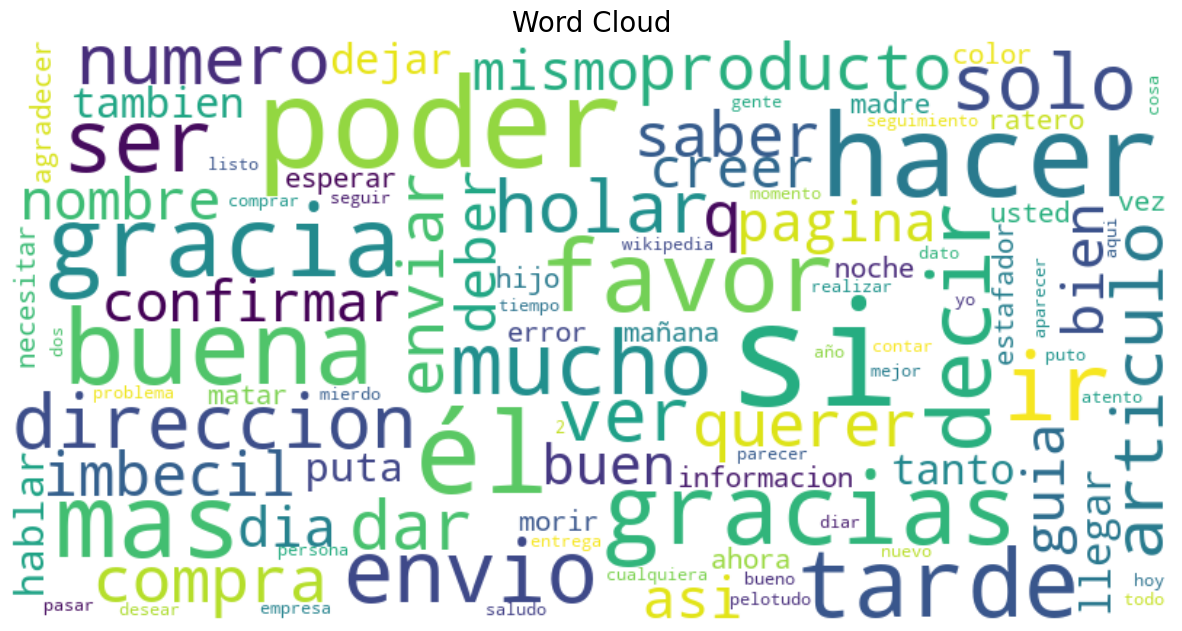

In [83]:
word_cloud(df['message_clean'])

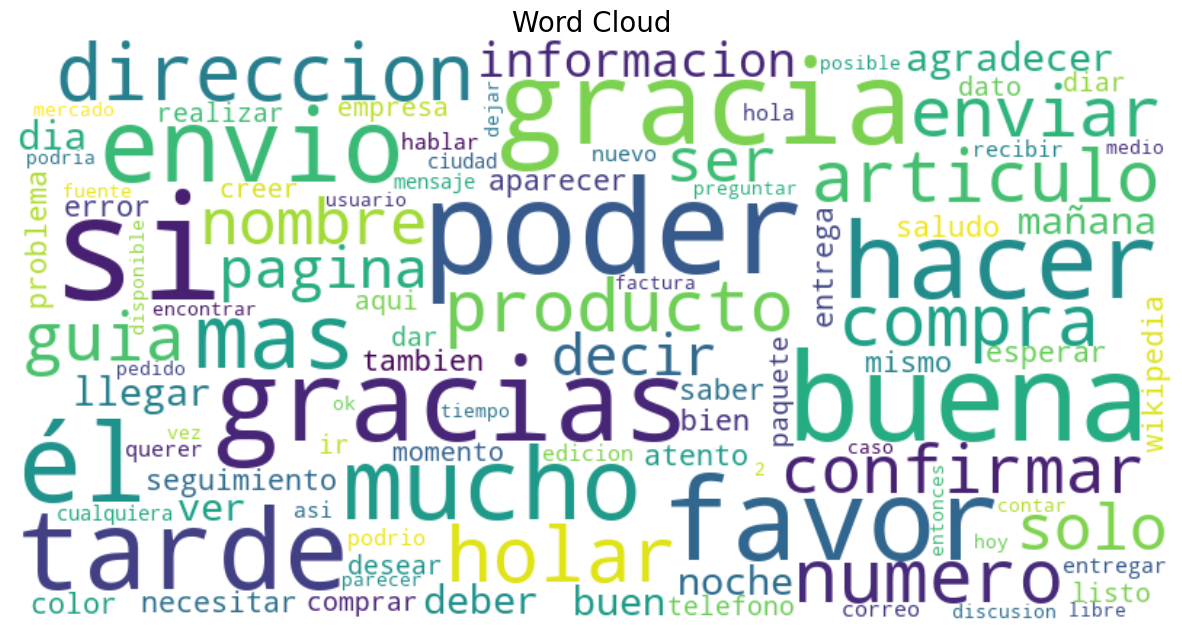

In [84]:
word_cloud(df_normal['message_clean'])

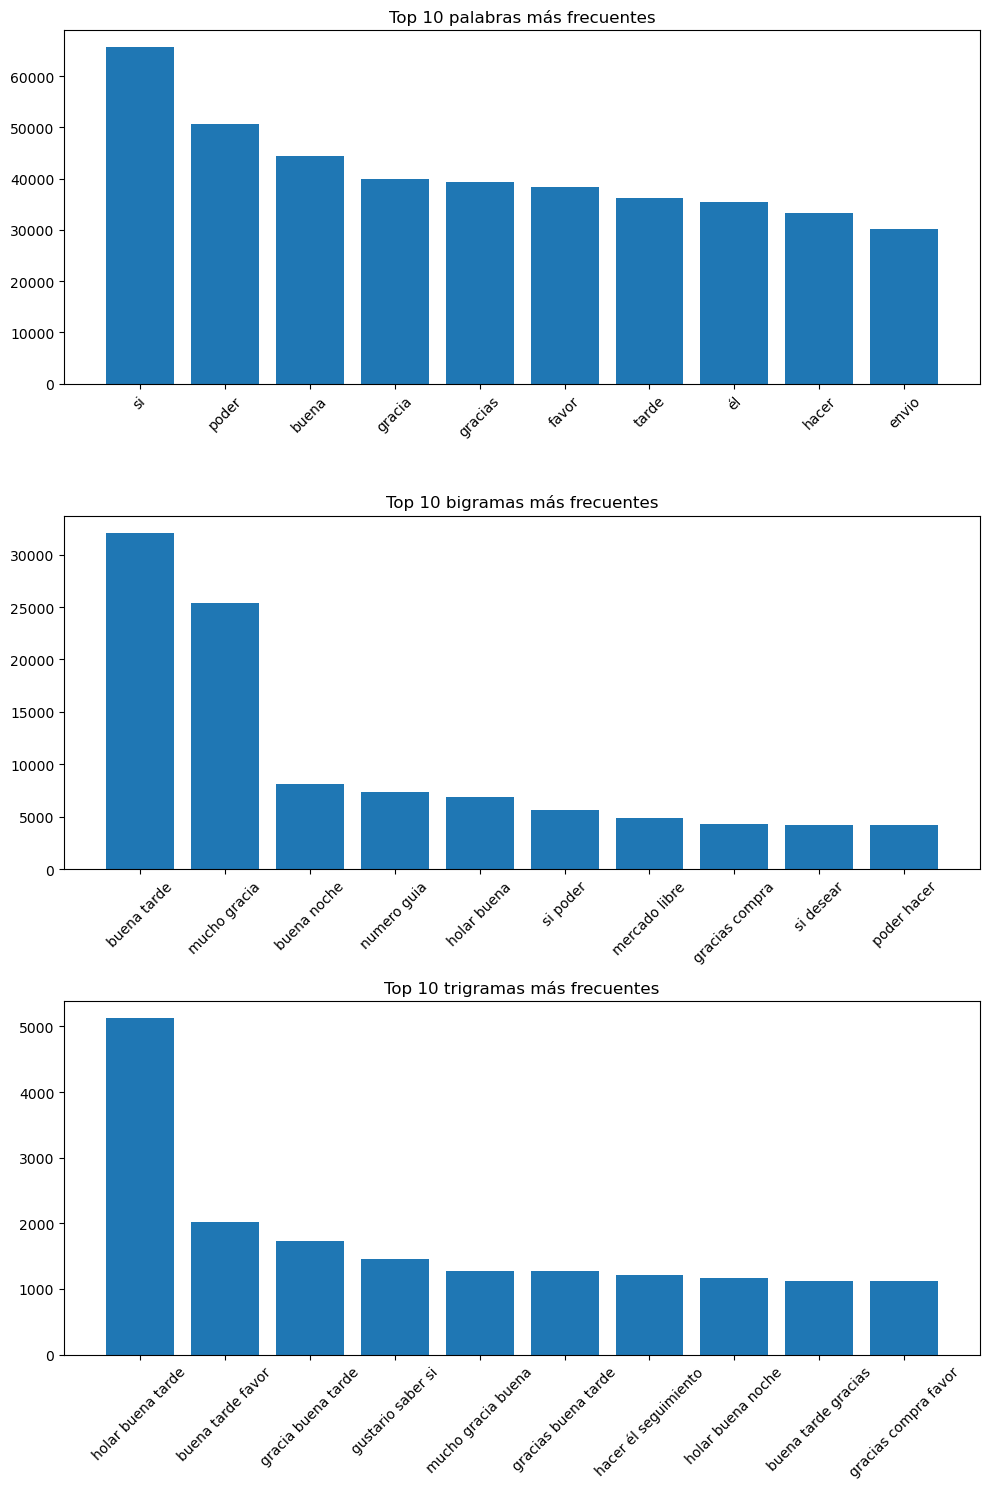

In [91]:
plot_ngram_frequencies(df_normal, 'message_clean')

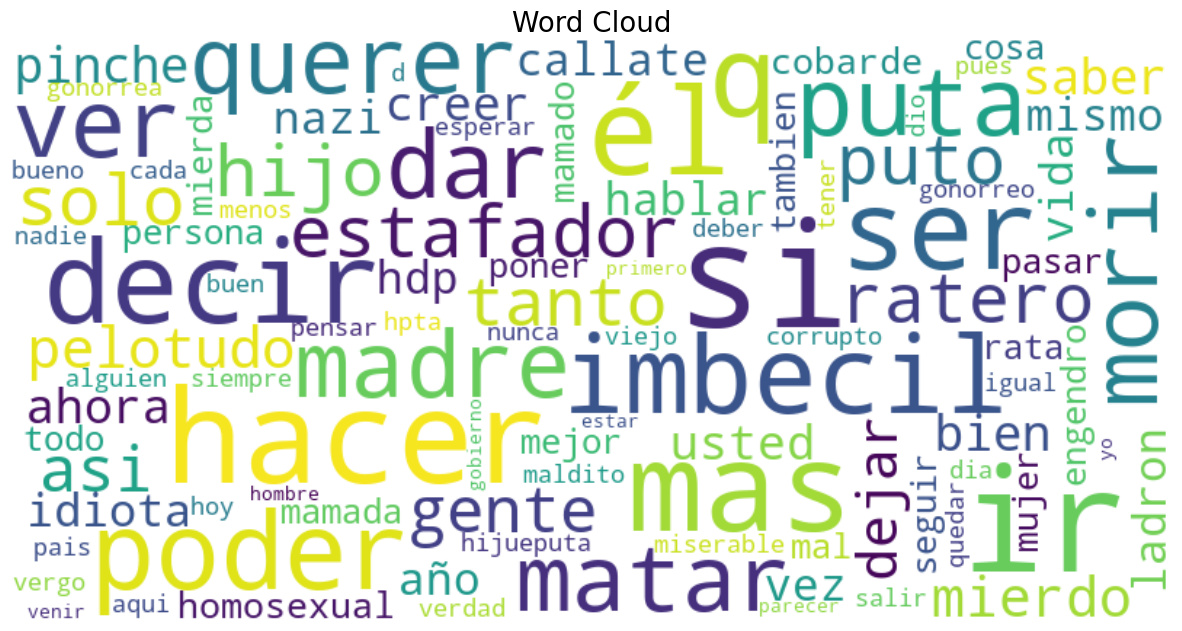

In [87]:
word_cloud(df_toxico['message_clean'])

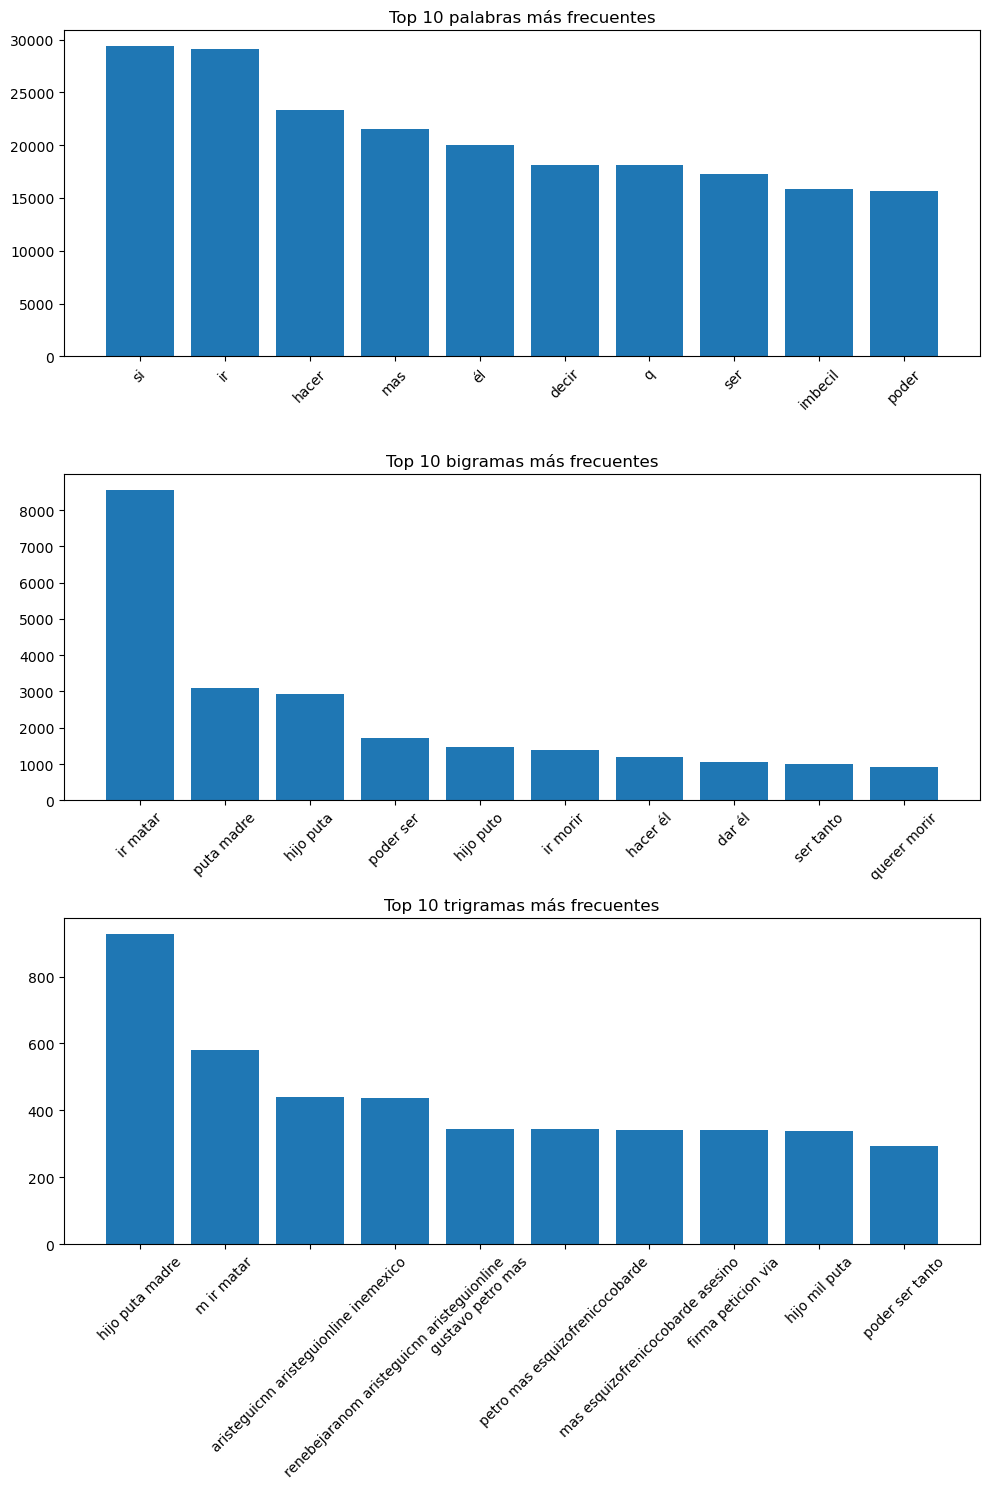

In [90]:
plot_ngram_frequencies(df_toxico, 'message_clean')

Durante la fase inicial de procesamiento, se empiezan a  observar palabras que logran destacarse. Sin embargo, se enfrentan desafíos con la lematización, así como con la presencia de palabras de un solo carácter, tales como 'q' o 'm', que idealmente no deberían incluirse. Además, se detecto que algunas stopwords no fueron eliminadas de manera eficaz. Este conjunto de problemas subraya la necesidad de realizar un nuevo procesamiento de los datos. Para abordar estas dificultades de manera más efectiva, se decidi+o desarrollar y emplear un diccionario de stopwords personalizado ademas de excluir estas palabras con longitud de un caracter

# Segunda limpieza

In [116]:

# Diccionario propio stopwords
my_stopwords = set([
    "una", "un", "él", "el", "los", "esto", "estos", "es", "en", "lo", "de", "y", "a", "que", 
    "la", "las", "para", "con", "no", "se", "del", "al", "como", "más", "pero", "sus", "le", 
    "ya", "o", "este", "por", "qué", "nos", "ni", "entre", "cuando", "también", "sino", "sobre", 
    "este", "ya", "si", "su", "aquí", "allá", "hay", "fue", "era", "son", "han", "había", "tengo", 
    "tienes", "tenemos", "tienen", "tenga", "tengas", "tenemos", "tengan", "mi", "mis", "tu", "tus", 
    "nuestro", "nuestra", "nuestros", "nuestras", "vuestro", "vuestra", "vuestros", "vuestras", 
    "este", "estas", "ese", "esos", "esa", "esas", "aquel", "aquellos", "aquella", "aquellas", 
    "mío", "mía", "míos", "mías", "tuyo", "tuya", "tuyos", "tuyas", "suyo", "suya", "suyos", "suyas",
    "nada", "todo", "todos", "todas", "mucho", "muchos", "mucha", "muchas", "poco", "pocos", "poca", 
    "pocas", "alguno", "alguna", "algunos", "algunas", "ninguno", "ninguna", "ningunos", "ningunas",
    "cualquier", "cualquiera", "cualquieras", "cada", "cierto", "ciertos", "cierta", "ciertas",
    "varios", "varias", "tantos", "tantas", "demasiado", "demasiados", "demasiada", "demasiadas",
    "bastante", "bastantes", "mismo", "misma", "mismos", "mismas", "tan", "tanto", "tanta", "tantos", "tantas",
    "algo", "alguien", "quien", "quienes", "cuyo", "cuya", "cuyos", "cuyas",
    "dónde", "cuándo", "cómo", "porqué", "por qué", "cuál", "cuáles", "quién", "quiénes",
    "dónde", "adónde", "de dónde", "hacia dónde","mas","más"
])

def clean_message(row, stopwords):
    if pd.notna(row):  # Verifica que la fila no sea NaN
        # Convierte la fila a string y tokeniza el mensaje
        tokens = word_tokenize(str(row))
        # Elimina palabras que solo tienen un carácter y no están en el conjunto de stopwords
        tokens = [word for word in tokens if len(word) > 1 or word in stopwords]
        # Elimina stopwords
        tokens = [word for word in tokens if word not in stopwords]
        # Une los tokens para formar el string limpio
        return ' '.join(tokens)
    return ""  # Retorna un string vacío si la fila es NaN

# Aplica la función de limpieza a la columna 'message_clean'
df['message_clean2'] = df['message_clean'].apply(lambda x: clean_message(x, my_stopwords))






In [117]:
df.head()

message  \
0                                                                                                                                               Hola, dale actualizar a la pagina o la tecla F5   
1  Ningún mujer te va a dejar por un error. porque todos somos humanos y el algún momento la cagamos pero siempre hay la oportunidad de mejorar en la cagas que uno hace y más si te hace feliz   
2                                Entonces, si está haciendo una correspondencia en R ^ 2, ¿cómo dibujaría G (x) = {y es un elemento de R2 tal que el producto escalar de x e y es 0} si G (3,4)   
3                                                                                                                                                   victoria con el pelito corto me voy a matar   
4                                                                                                      @LoloPeniche Periodista!!!!!\nEs una puta verdulera la HDSPTM... https://t.co/6wyiTra4ko   

   label  \
0      0   
1      1   
2      0   
3      1   
4      1   

                                                                                                      message_clean  \
0                                                                             hola dalar actualizar pagina tecla f5   
1  ningun mujer ir dejar error humano algun momento cagar siempre oportunidad mejorar caga hacer mas si hacer feliz   
2                  entonces si hacer correspondencia r 2 dibujaria g x elemento r2 tal producto escalar x 0 si g 34   
3                                                                                    victoria pelito corto ir matar   
4                                                                      lolopeniche periodista puta verdulero hdsptm   

                                                                                              message_clean2  
0                                                                      hola dalar actualizar pagina tecla f5  
1  ningun mujer ir dejar error humano algun momento cagar siempre oportunidad mejorar caga hacer hacer feliz  
2                               entonces hacer correspondencia dibujaria elemento r2 tal producto escalar 34  
3                                                                             victoria pelito corto ir matar  
4                                                               lolopeniche periodista puta verdulero hdsptm

In [118]:
df.to_csv('data_toxic_cleaned2.csv', index=False)

In [145]:
df = pd.read_csv("data_toxic_cleaned2.csv")

# Descriptivo Actualizado

Tras realizar nuevamente el preprocesamiento, se llevó a cabo un análisis descriptivo para comparar los comentarios tóxicos frente a los no tóxicos. Este análisis se centró en identificar patrones, diferencias en la frecuencia de palabras, uso de bigramas y trigramas, así como otras características lingüísticas distintivas que diferencian ambos tipos de comentarios.

In [146]:
df_normal = df[df['label']==0]
df_toxico = df[df['label']==1]

## Comentarios buenos

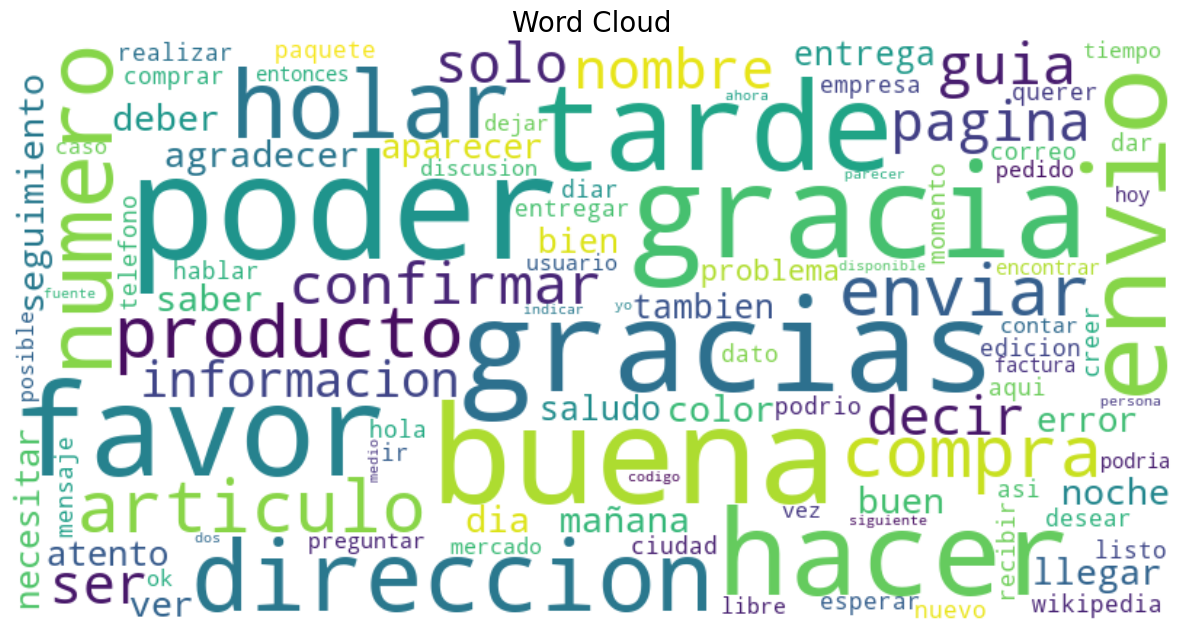

In [147]:
word_cloud(df_normal['message_clean2'])


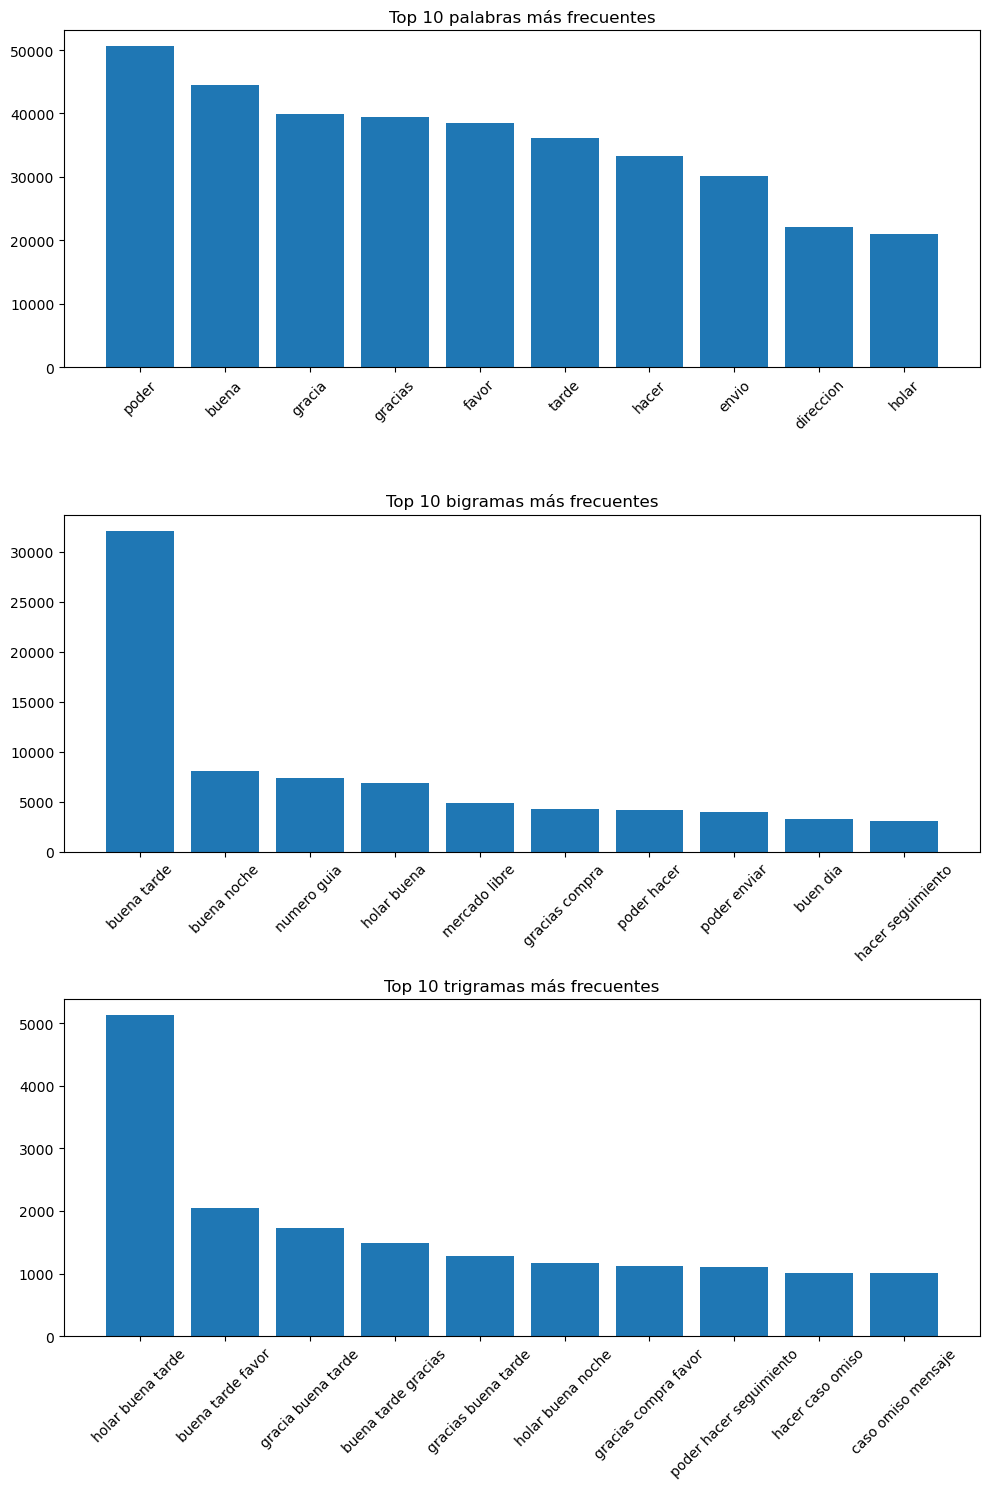

In [148]:
plot_ngram_frequencies(df_normal, 'message_clean2')

Destacan los siguientes insights:

* Uso frecuente de cortesía: Las palabras y frases más comunes en los comentarios incluyen términos de cortesía como "gracias", "favor", y saludos como "hola", "buenas tardes". Esto indica un tono generalmente educado y amigable en los intercambios.

* Comunicación transaccional y de servicio al cliente: La presencia de palabras como "producto", "envío", "dirección", "compra" y "entrega" indica que muchos de los comentarios podrían estar relacionados con transacciones comerciales o interacciones de servicio al cliente.

* Bigramas y trigramas de agradecimiento y saludos: Los bigramas y trigramas más frecuentes involucran combinaciones de saludos ("hola buena", "buen día") y expresiones de gratitud ("gracias favor", "gracias buena tarde"). Esto refuerza la idea de un comportamiento cortés y la importancia de las normas sociales en las comunicaciones.

* Peticiones y respuestas: El uso de palabras como "confirmar", "poder", "hacer" y "necesitar" en el contexto de otras palabras identificadas sugiere que los comentarios buenos están frecuentemente ligados a la solicitud de información o a la confirmación de acciones, lo cual es típico en contextos de atención al cliente.


## Malos comentarios

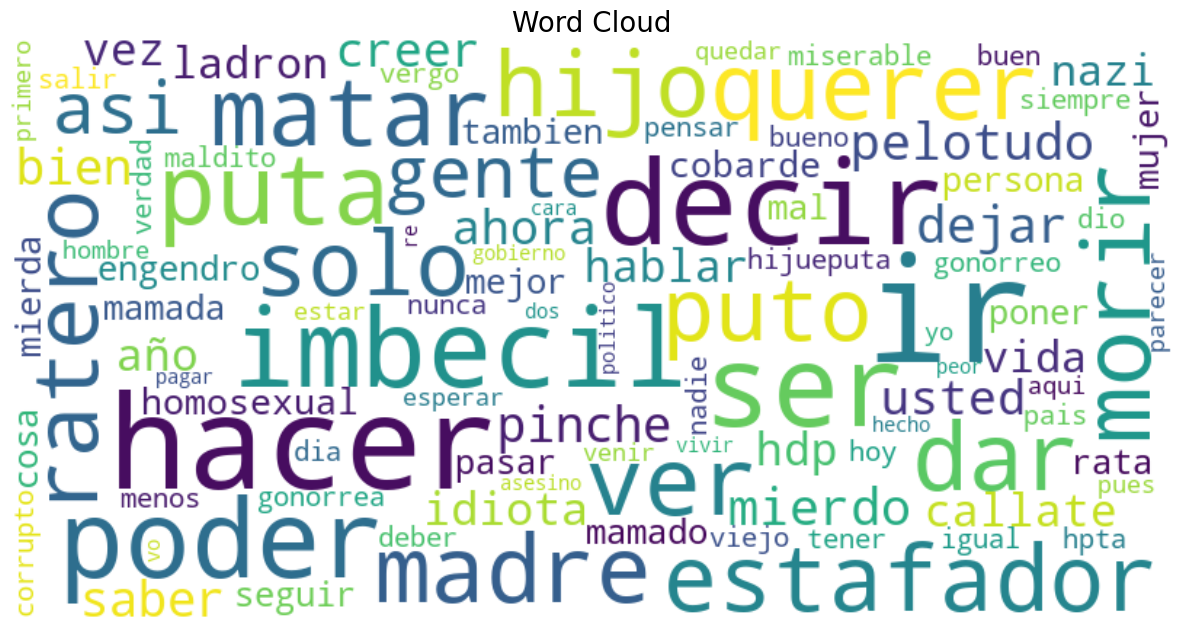

In [149]:
word_cloud(df_toxico['message_clean2'])

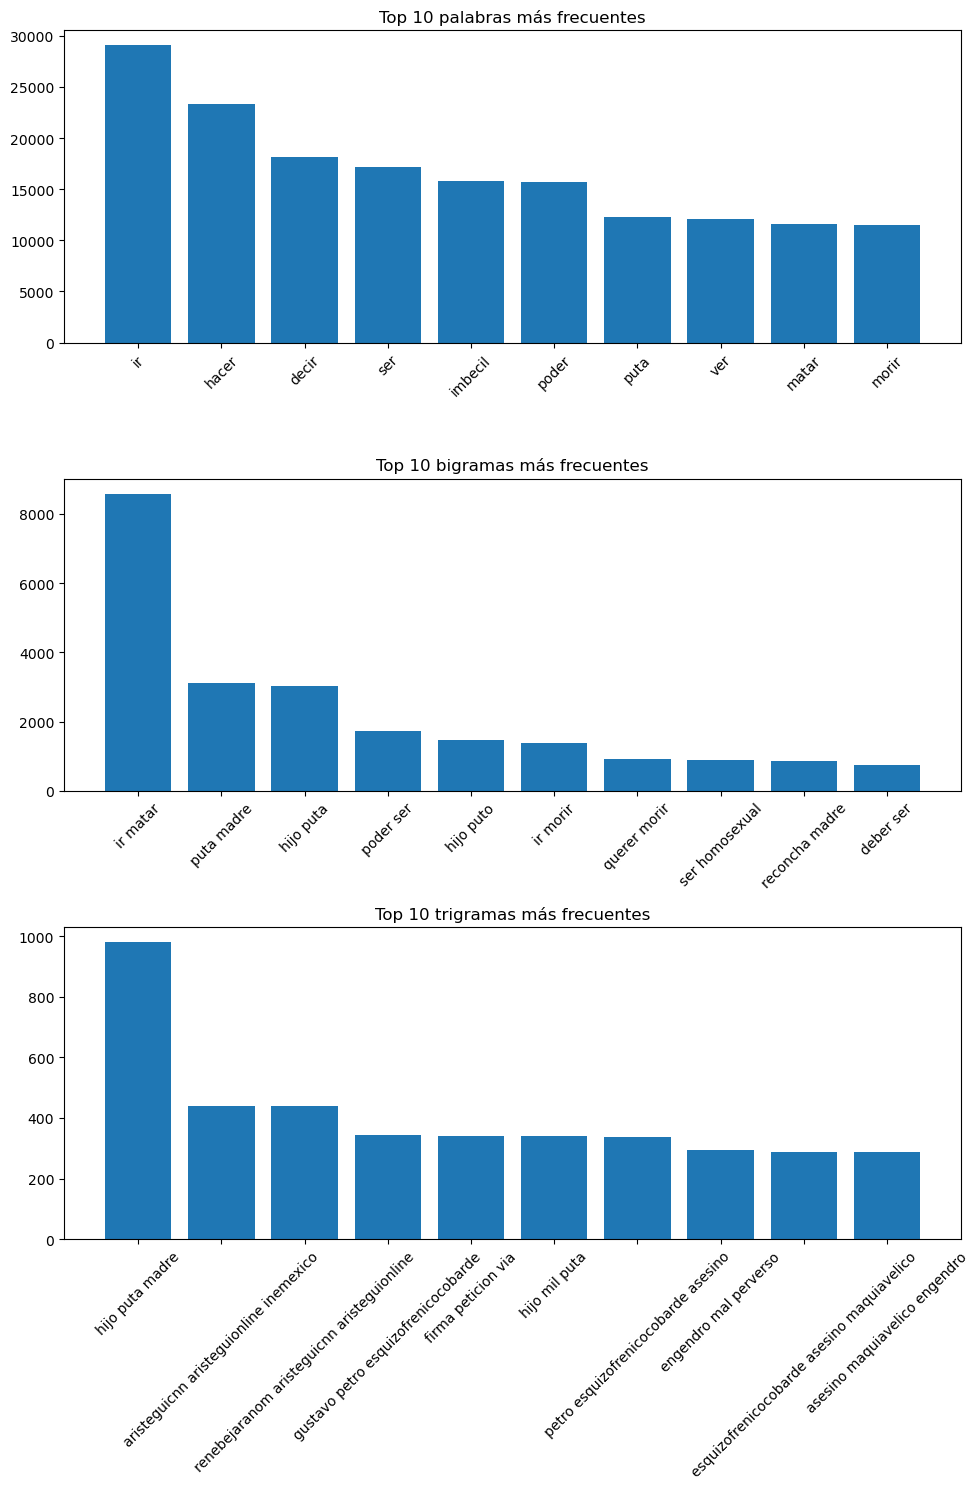

In [150]:
plot_ngram_frequencies(df_toxico, 'message_clean2')

Destacan los siguientes insights:

* Presencia de lenguaje ofensivo y agresivo: Los términos más visibles en la nube de palabras indican un uso significativo de lenguaje ofensivoy insultos. Esto indica que la toxicidad en estos comentarios está marcada por un lenguaje explícitamente agresivo y despectivo.

* Insultos y descalificaciones personales: Las palabras y frases más frecuentes incluyen insultos que descalifican la inteligencia, la integridad y la moral de las personas, lo que apunta a ataques personales como un mecanismo común en los comentarios tóxicos.

* Bigramas y trigramas con insultos directos: Los bigramas y trigramas muestran una tendencia a insultar directamente a la familia de las personas.

* Potencial de violencia verbal: Algunos de los bigramas y trigramas implican amenazas o deseos de daño.

## Modelamiento 

In [151]:
df.head()

message  \
0                                                                                                                                               Hola, dale actualizar a la pagina o la tecla F5   
1  Ningún mujer te va a dejar por un error. porque todos somos humanos y el algún momento la cagamos pero siempre hay la oportunidad de mejorar en la cagas que uno hace y más si te hace feliz   
2                                Entonces, si está haciendo una correspondencia en R ^ 2, ¿cómo dibujaría G (x) = {y es un elemento de R2 tal que el producto escalar de x e y es 0} si G (3,4)   
3                                                                                                                                                   victoria con el pelito corto me voy a matar   
4                                                                                                      @LoloPeniche Periodista!!!!!\nEs una puta verdulera la HDSPTM... https://t.co/6wyiTra4ko   

   label  \
0      0   
1      1   
2      0   
3      1   
4      1   

                                                                                                      message_clean  \
0                                                                             hola dalar actualizar pagina tecla f5   
1  ningun mujer ir dejar error humano algun momento cagar siempre oportunidad mejorar caga hacer mas si hacer feliz   
2                  entonces si hacer correspondencia r 2 dibujaria g x elemento r2 tal producto escalar x 0 si g 34   
3                                                                                    victoria pelito corto ir matar   
4                                                                      lolopeniche periodista puta verdulero hdsptm   

                                                                                              message_clean2  
0                                                                      hola dalar actualizar pagina tecla f5  
1  ningun mujer ir dejar error humano algun momento cagar siempre oportunidad mejorar caga hacer hacer feliz  
2                               entonces hacer correspondencia dibujaria elemento r2 tal producto escalar 34  
3                                                                             victoria pelito corto ir matar  
4                                                               lolopeniche periodista puta verdulero hdsptm

In [152]:
df = df[['message_clean2','label']]

In [153]:
df.isnull().sum()

message_clean2    337
label               0
dtype: int64

Al aplicar el filtrado de stopwords, se identificó que un total de 317 comentarios resultaron en nulos de una muestra aproximada de 514,000. Esto representa una proporción muy pequeña del conjunto de datos (aproximadamente el 0.06%). Dada su insignificante representación estadística y su nula aportación al análisis posterior, se tomó la decisión de excluir estos comentarios del conjunto de datos para continuar con el procesamiento y análisis subsiguientes.

In [154]:
df = df.dropna(subset=['message_clean2'])

El análisis exploratorio confirmó que las etiquetas de los datos están bien balanceadas, con un 60% para una clase y un 40% para la otra. Se procedió a dividir el conjunto de datos en un set de entrenamiento que comprende el 80% del total y un set de prueba que constituye el 20% restante.

In [155]:
from sklearn.model_selection import train_test_split

X = df['message_clean2']  
y = df['label']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Entrenamiento (X_train): {X_train.shape[0]} registros")
print(f"Prueba (X_test): {X_test.shape[0]} registros")

Entrenamiento (X_train): 411374 registros
Prueba (X_test): 102844 registros


Para dar peso a las palabras dentro de los datos de texto, se empleará el método de vectorización **TF-IDF (Term Frequency-Inverse Document Frequency).** Este enfoque asigna pesos a las palabras basándose en su frecuencia en un documento y su rareza a través de los documentos. De esta manera, las palabras comunes que aparecen en muchos documentos (como las stopwords) reciben un peso menor, mientras que las palabras únicas que pueden ser más relevantes para la comprensión del contenido reciben un peso mayor.

In [158]:
# Vectorización TF-IDF
tfidf_vectorizer = TfidfVectorizer()
# Ajustar el vectorizador a los datos de entrenamiento y transformarlos
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)




Para la comparación de modelos de clasificación, se emplearán diversas métricas de rendimiento y se analizarán tanto en los conjuntos de entrenamiento como de prueba. Esto permitirá detectar si hay sobreajuste (overfitting).

Las métricas que se evaluarán incluyen:

* AUC: Proporciona una medida agregada del rendimiento en todos los umbrales de clasificación.
* Accuracy: Mide la proporción de predicciones correctas sobre el total de casos.
* F1-Score: Combina la precisión y la sensibilidad en una sola métrica, útil cuando las clases están desbalanceadas.
* Matrices de Confusión: Tablas que muestran las clasificaciones correctas.
* Además, se registrará el tiempo que cada modelo tarda en entrenarse (tiempos de entrenamiento) y el tiempo que tarda en hacer predicciones sobre nuevos datos (tiempos de ejecución).

Los modelos que se compararán pertenecen a la familia de algoritmos basados en árboles y ensamblajes, que son conocidos por su eficacia en tareas de clasificación:

* LightGBM
* XGBoost
* Random Forest
* DecisionTreeClassifier
* GradientBoostingClassifier



### Lightgbm

[LightGBM] [Info] Number of positive: 174770, number of negative: 236604
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 15.890262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 418927
[LightGBM] [Info] Number of data points in the train set: 411374, number of used features: 15851
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.424845 -> initscore=-0.302917
[LightGBM] [Info] Start training from score -0.302917
Wall time: 59.4 s

Training Accuracy score: 0.9560545877960201
Testing Accuracy score: 0.9553206798646494

Classification Report (train set):
              precision    recall  f1-score   support

      Normal       0.94      0.99      0.96    236604
      Toxico       0.99      0.91      0.95    174770

    accuracy                           0.96    411374
   macro avg       0.96      0.95      0.95    411374
weighted avg       0.96      0.96      0.96    411374


Classification Report (T

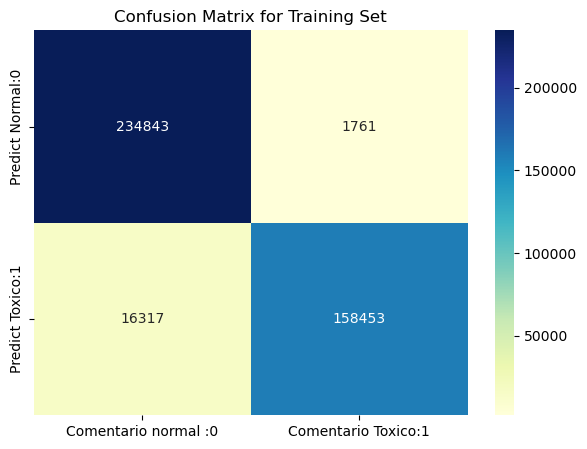

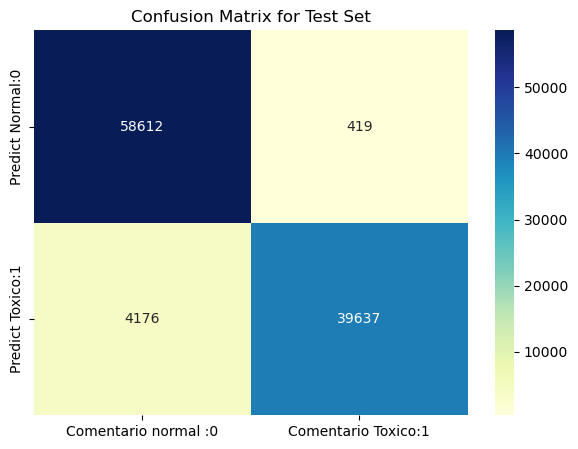

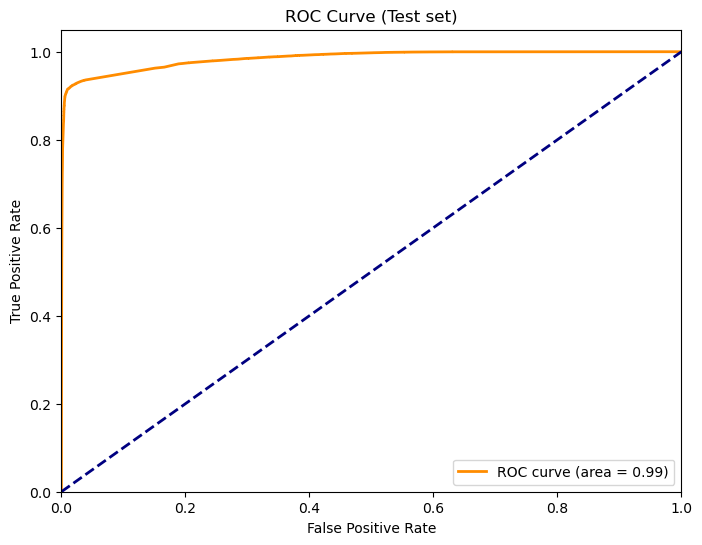

In [173]:

model = LGBMClassifier(random_state=42)

%time model.fit(X_train_tfidf, y_train)

# Realizar predicciones en los conjuntos de entrenamiento y prueba
y_pred_train = model.predict(X_train_tfidf)
y_pred_test = model.predict(X_test_tfidf)

# Calcular y mostrar la precisión para los conjuntos de entrenamiento y prueba
print("\nTraining Accuracy score:", accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:", accuracy_score(y_test, y_pred_test))

# informe de clasificación train
print("\nClassification Report (train set):")
print(classification_report(y_train, y_pred_train, target_names=['Normal', 'Toxico']))

#  informe de clasificación test
print("\nClassification Report (Test set):")
print(classification_report(y_test, y_pred_test, target_names=['Normal', 'Toxico']))

# Matriz de confusión train
cm_train = confusion_matrix(y_train, y_pred_train)
cm_train_matrix = pd.DataFrame(data=cm_train,  columns=['Comentario normal :0', 'Comentario Toxico:1'], 
                              index=['Predict Normal:0', 'Predict Toxico:1'])

plt.figure(figsize=(7,5))
sns.heatmap(cm_train_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix for Training Set')
plt.show()

# Matriz de confusión test
cm_test = confusion_matrix(y_test, y_pred_test)
cm_test_matrix = pd.DataFrame(data=cm_test, columns=['Comentario normal :0', 'Comentario Toxico:1'], 
                              index=['Predict Normal:0', 'Predict Toxico:1'])

plt.figure(figsize=(7,5))
sns.heatmap(cm_test_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix for Test Set')
plt.show()


from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_scores, title='ROC Curve'):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# se obtienen puntuaciones de las probabilidades para el conjunto de entrenamiento y prueba
y_scores_train = lgbm.predict_proba(X_train_tfidf)[:, 1]
y_scores_test = lgbm.predict_proba(X_test_tfidf)[:, 1]

# Dibuja la curva ROC para el conjunto de prueba
plot_roc_curve(y_test, y_scores_test, 'ROC Curve (Test set)')


model_filename = 'light_gbm1.pickle'
with open(model_filename, 'wb') as model_file:
    pickle.dump(model, model_file)

# Xgboost

C:\Users\O004607\Anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Wall time: 17min 31s

Training Accuracy score: 0.9536747582491845
Testing Accuracy score: 0.9526370036171289

Classification Report (train set):
              precision    recall  f1-score   support

      Normal       0.93      0.99      0.96    236604
      Toxico       0.99      0.90      0.94    174770

    accuracy                           0.95    411374
   macro avg       0.96      0.95      0.95    411374
weighted avg       0.96      0.95      0.95    411374


Classification Report (Test set):
              precision    recall  f1-score   support

      Normal       0.93      0.99      0.96     59031
      Toxico       0.99      0.90      0.94     43813

    accuracy                           0.95    102844
   macro avg       0.96      0.95      0.95    102844
weighted avg       0.96      0.95      0.95    102844



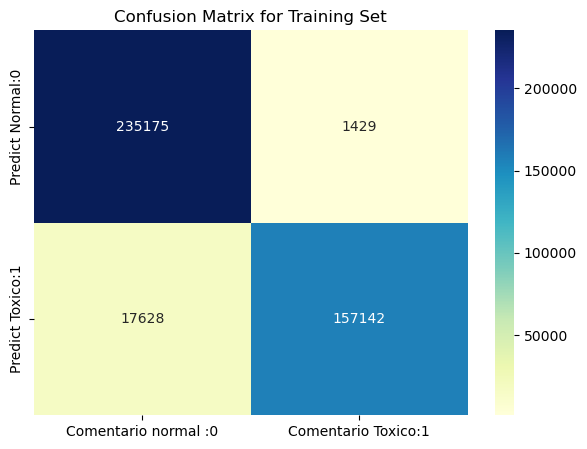

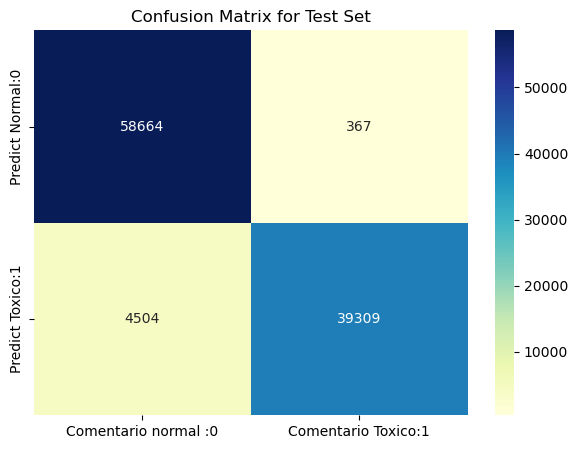

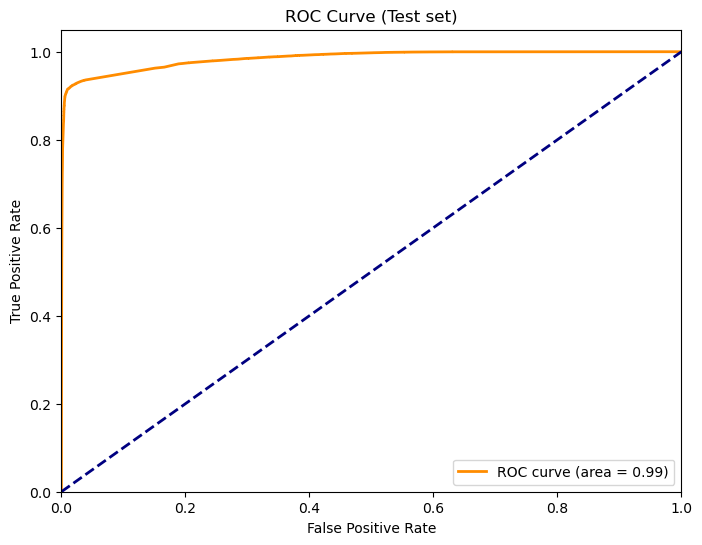

In [174]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
%time model.fit(X_train_tfidf, y_train)

# Realizar predicciones en los conjuntos de entrenamiento y prueba
y_pred_train = model.predict(X_train_tfidf)
y_pred_test = model.predict(X_test_tfidf)

# Calcular y mostrar la precisión para los conjuntos de entrenamiento y prueba
print("\nTraining Accuracy score:", accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:", accuracy_score(y_test, y_pred_test))

# informe de clasificación train
print("\nClassification Report (train set):")
print(classification_report(y_train, y_pred_train, target_names=['Normal', 'Toxico']))

#  informe de clasificación test
print("\nClassification Report (Test set):")
print(classification_report(y_test, y_pred_test, target_names=['Normal', 'Toxico']))

# Matriz de confusión train
cm_train = confusion_matrix(y_train, y_pred_train)
cm_train_matrix = pd.DataFrame(data=cm_train,  columns=['Comentario normal :0', 'Comentario Toxico:1'], 
                              index=['Predict Normal:0', 'Predict Toxico:1'])

plt.figure(figsize=(7,5))
sns.heatmap(cm_train_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix for Training Set')
plt.show()

# Matriz de confusión test
cm_test = confusion_matrix(y_test, y_pred_test)
cm_test_matrix = pd.DataFrame(data=cm_test, columns=['Comentario normal :0', 'Comentario Toxico:1'], 
                              index=['Predict Normal:0', 'Predict Toxico:1'])

plt.figure(figsize=(7,5))
sns.heatmap(cm_test_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix for Test Set')
plt.show()


# se obtienen puntuaciones de las probabilidades para el conjunto de entrenamiento y prueba
y_scores_train = lgbm.predict_proba(X_train_tfidf)[:, 1]
y_scores_test = lgbm.predict_proba(X_test_tfidf)[:, 1]

# Dibuja la curva ROC para el conjunto de prueba
plot_roc_curve(y_test, y_scores_test, 'ROC Curve (Test set)')

model_filename = 'xgb1.pickle'
with open(model_filename, 'wb') as model_file:
    pickle.dump(model, model_file)

### Random Forest

Wall time: 26.4 s

Training Accuracy score: 0.6017614141875762
Testing Accuracy score: 0.6009587336159621

Classification Report (train set):
              precision    recall  f1-score   support

      Normal       0.59      1.00      0.74    236604
      Toxico       1.00      0.06      0.12    174770

    accuracy                           0.60    411374
   macro avg       0.80      0.53      0.43    411374
weighted avg       0.76      0.60      0.48    411374


Classification Report (Test set):
              precision    recall  f1-score   support

      Normal       0.59      1.00      0.74     59031
      Toxico       1.00      0.06      0.12     43813

    accuracy                           0.60    102844
   macro avg       0.79      0.53      0.43    102844
weighted avg       0.76      0.60      0.48    102844



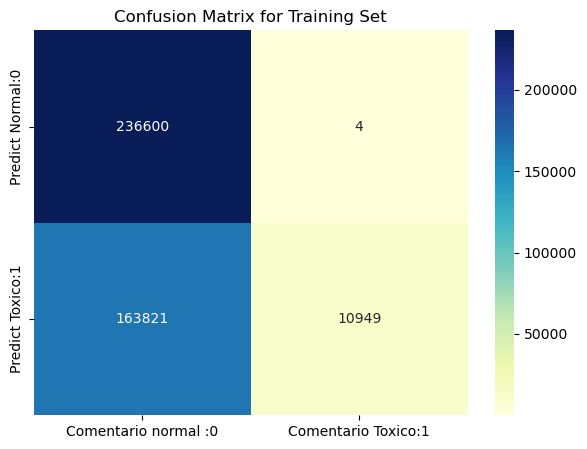

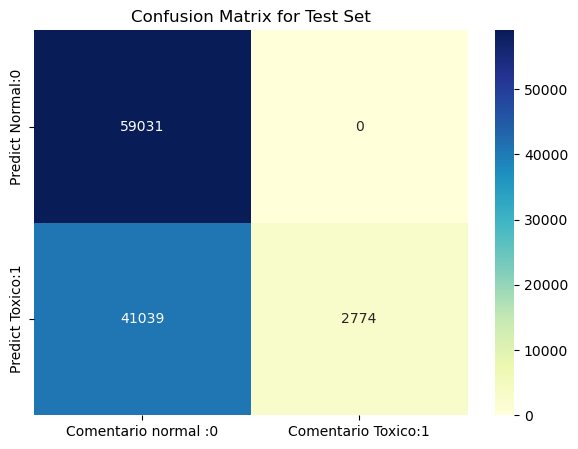

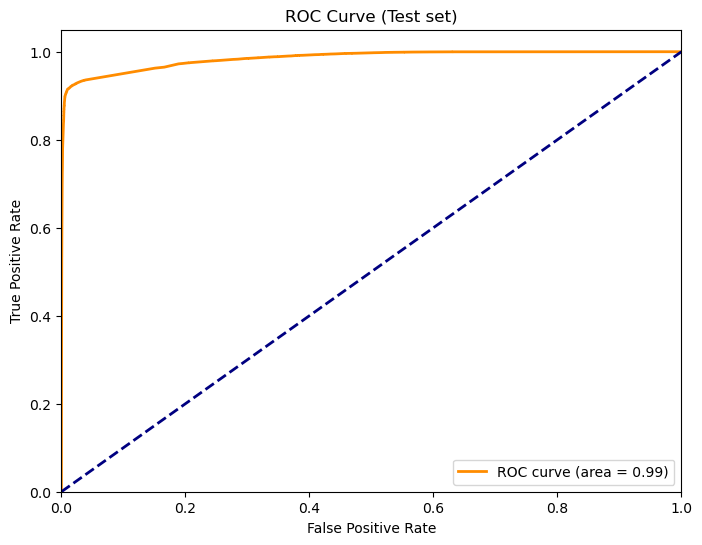

In [175]:
model = RandomForestClassifier(max_depth=15, random_state=42)

%time model.fit(X_train_tfidf, y_train)

# Realizar predicciones en los conjuntos de entrenamiento y prueba
y_pred_train = model.predict(X_train_tfidf)
y_pred_test = model.predict(X_test_tfidf)

# Calcular y mostrar la precisión para los conjuntos de entrenamiento y prueba
print("\nTraining Accuracy score:", accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:", accuracy_score(y_test, y_pred_test))

# informe de clasificación train
print("\nClassification Report (train set):")
print(classification_report(y_train, y_pred_train, target_names=['Normal', 'Toxico']))

#  informe de clasificación test
print("\nClassification Report (Test set):")
print(classification_report(y_test, y_pred_test, target_names=['Normal', 'Toxico']))

# Matriz de confusión train
cm_train = confusion_matrix(y_train, y_pred_train)
cm_train_matrix = pd.DataFrame(data=cm_train,  columns=['Comentario normal :0', 'Comentario Toxico:1'], 
                              index=['Predict Normal:0', 'Predict Toxico:1'])

plt.figure(figsize=(7,5))
sns.heatmap(cm_train_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix for Training Set')
plt.show()

# Matriz de confusión test
cm_test = confusion_matrix(y_test, y_pred_test)
cm_test_matrix = pd.DataFrame(data=cm_test, columns=['Comentario normal :0', 'Comentario Toxico:1'], 
                              index=['Predict Normal:0', 'Predict Toxico:1'])

plt.figure(figsize=(7,5))
sns.heatmap(cm_test_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix for Test Set')
plt.show()


# se obtienen puntuaciones de las probabilidades para el conjunto de entrenamiento y prueba
y_scores_train = lgbm.predict_proba(X_train_tfidf)[:, 1]
y_scores_test = lgbm.predict_proba(X_test_tfidf)[:, 1]

# Dibuja la curva ROC para el conjunto de prueba
plot_roc_curve(y_test, y_scores_test, 'ROC Curve (Test set)')

### DecisionTreeClassifier

Wall time: 19.5 s

Training Accuracy score: 0.6854152182685342
Testing Accuracy score: 0.6863890941620319

Classification Report (train set):
              precision    recall  f1-score   support

      Normal       0.65      0.99      0.78    236604
      Toxico       0.95      0.27      0.43    174770

    accuracy                           0.69    411374
   macro avg       0.80      0.63      0.60    411374
weighted avg       0.78      0.69      0.63    411374


Classification Report (Test set):
              precision    recall  f1-score   support

      Normal       0.65      0.99      0.78     59031
      Toxico       0.95      0.28      0.43     43813

    accuracy                           0.69    102844
   macro avg       0.80      0.63      0.61    102844
weighted avg       0.78      0.69      0.63    102844



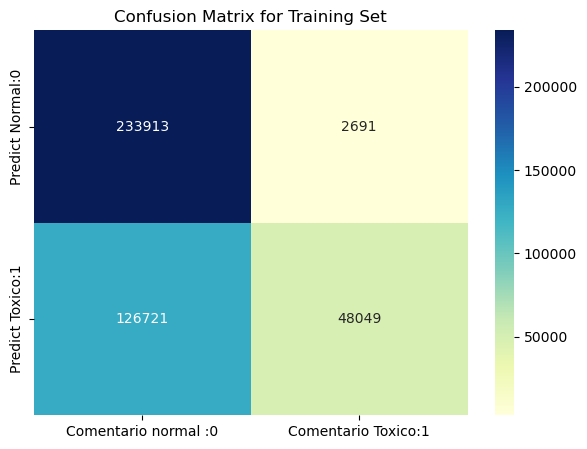

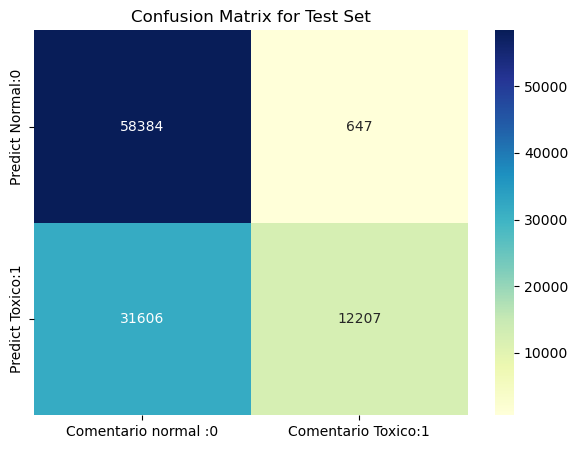

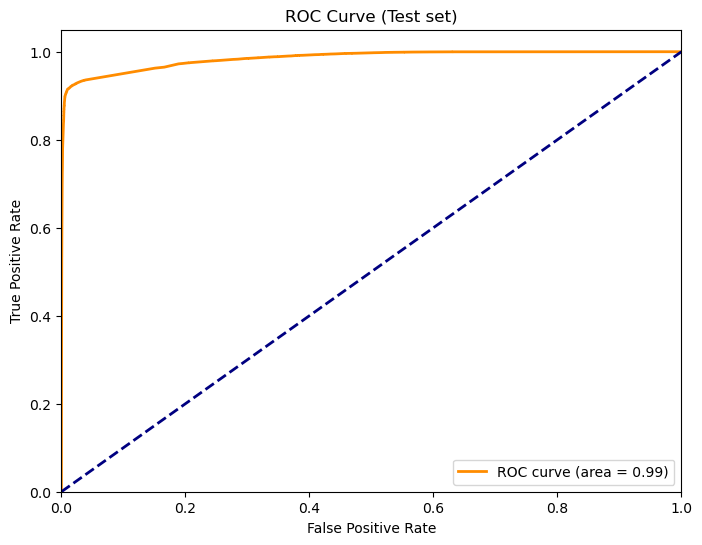

In [176]:
model = DecisionTreeClassifier(max_depth=10, random_state=42)
%time model.fit(X_train_tfidf, y_train)

# Realizar predicciones en los conjuntos de entrenamiento y prueba
y_pred_train = model.predict(X_train_tfidf)
y_pred_test = model.predict(X_test_tfidf)

# Calcular y mostrar la precisión para los conjuntos de entrenamiento y prueba
print("\nTraining Accuracy score:", accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:", accuracy_score(y_test, y_pred_test))

# informe de clasificación train
print("\nClassification Report (train set):")
print(classification_report(y_train, y_pred_train, target_names=['Normal', 'Toxico']))

#  informe de clasificación test
print("\nClassification Report (Test set):")
print(classification_report(y_test, y_pred_test, target_names=['Normal', 'Toxico']))

# Matriz de confusión train
cm_train = confusion_matrix(y_train, y_pred_train)
cm_train_matrix = pd.DataFrame(data=cm_train,  columns=['Comentario normal :0', 'Comentario Toxico:1'], 
                              index=['Predict Normal:0', 'Predict Toxico:1'])

plt.figure(figsize=(7,5))
sns.heatmap(cm_train_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix for Training Set')
plt.show()

# Matriz de confusión test
cm_test = confusion_matrix(y_test, y_pred_test)
cm_test_matrix = pd.DataFrame(data=cm_test, columns=['Comentario normal :0', 'Comentario Toxico:1'], 
                              index=['Predict Normal:0', 'Predict Toxico:1'])

plt.figure(figsize=(7,5))
sns.heatmap(cm_test_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix for Test Set')
plt.show()


# se obtienen puntuaciones de las probabilidades para el conjunto de entrenamiento y prueba
y_scores_train = lgbm.predict_proba(X_train_tfidf)[:, 1]
y_scores_test = lgbm.predict_proba(X_test_tfidf)[:, 1]

# Dibuja la curva ROC para el conjunto de prueba
plot_roc_curve(y_test, y_scores_test, 'ROC Curve (Test set)')

### GradientBoostingClassifier

Wall time: 10min 43s

Training Accuracy score: 0.9109277688915682
Testing Accuracy score: 0.9116428765897865

Classification Report (train set):
              precision    recall  f1-score   support

      Normal       0.87      1.00      0.93    236604
      Toxico       0.99      0.80      0.88    174770

    accuracy                           0.91    411374
   macro avg       0.93      0.90      0.91    411374
weighted avg       0.92      0.91      0.91    411374


Classification Report (Test set):
              precision    recall  f1-score   support

      Normal       0.87      1.00      0.93     59031
      Toxico       0.99      0.80      0.89     43813

    accuracy                           0.91    102844
   macro avg       0.93      0.90      0.91    102844
weighted avg       0.92      0.91      0.91    102844



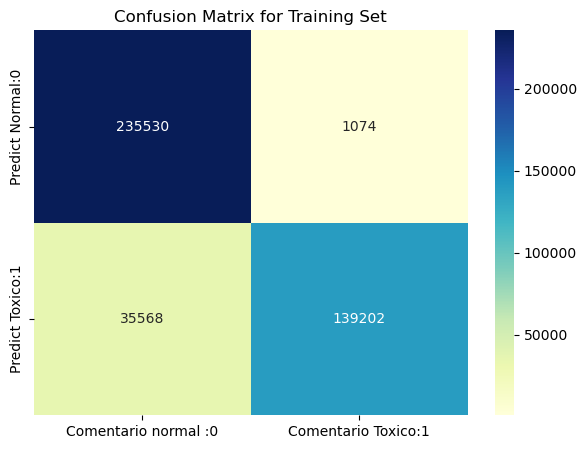

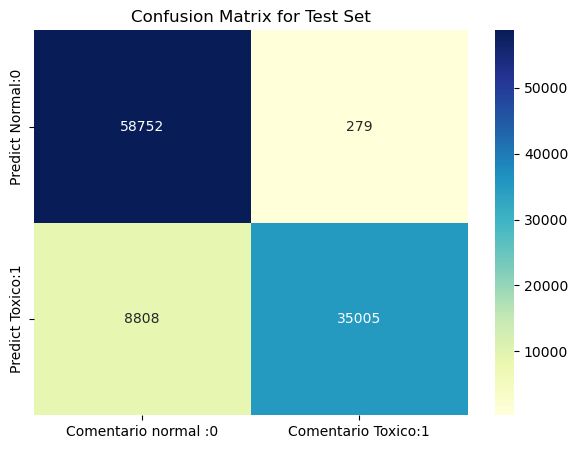

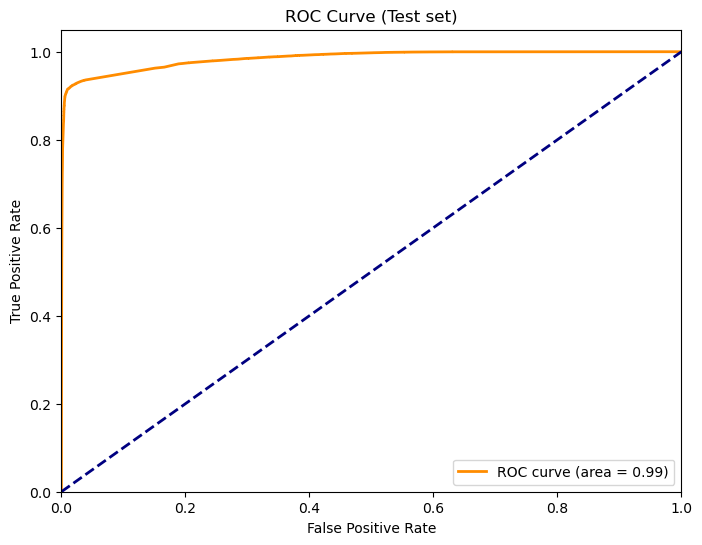

In [177]:
model = GradientBoostingClassifier(random_state=42)
%time model.fit(X_train_tfidf, y_train)

# Realizar predicciones en los conjuntos de entrenamiento y prueba
y_pred_train = model.predict(X_train_tfidf)
y_pred_test = model.predict(X_test_tfidf)

# Calcular y mostrar la precisión para los conjuntos de entrenamiento y prueba
print("\nTraining Accuracy score:", accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:", accuracy_score(y_test, y_pred_test))

# informe de clasificación train
print("\nClassification Report (train set):")
print(classification_report(y_train, y_pred_train, target_names=['Normal', 'Toxico']))

#  informe de clasificación test
print("\nClassification Report (Test set):")
print(classification_report(y_test, y_pred_test, target_names=['Normal', 'Toxico']))

# Matriz de confusión train
cm_train = confusion_matrix(y_train, y_pred_train)
cm_train_matrix = pd.DataFrame(data=cm_train,  columns=['Comentario normal :0', 'Comentario Toxico:1'], 
                              index=['Predict Normal:0', 'Predict Toxico:1'])

plt.figure(figsize=(7,5))
sns.heatmap(cm_train_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix for Training Set')
plt.show()

# Matriz de confusión test
cm_test = confusion_matrix(y_test, y_pred_test)
cm_test_matrix = pd.DataFrame(data=cm_test, columns=['Comentario normal :0', 'Comentario Toxico:1'], 
                              index=['Predict Normal:0', 'Predict Toxico:1'])

plt.figure(figsize=(7,5))
sns.heatmap(cm_test_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix for Test Set')
plt.show()


# se obtienen puntuaciones de las probabilidades para el conjunto de entrenamiento y prueba
y_scores_train = lgbm.predict_proba(X_train_tfidf)[:, 1]
y_scores_test = lgbm.predict_proba(X_test_tfidf)[:, 1]

# Dibuja la curva ROC para el conjunto de prueba
plot_roc_curve(y_test, y_scores_test, 'ROC Curve (Test set)')

## Análisis de Métricas y Selección del Modelo

En la evaluación de modelos, se consideraron varias métricas clave: AUC (Área Bajo la Curva ROC, que mide la relación entre la tasa de verdaderos positivos y la tasa de falsos positivos), Precisión (Accuracy) se tomo la precisión ya que el problema no esta desblanceado entonces nos sirver para comparar y el F1-Score. 

**Comparación de Modelos**

* XGBoost y LightGBM muestran las mejores métricas y serán analizados más a fondo. Random Forest evidencia sobreajuste y DecisionTreeClassifier y GradientBoostingClassifier tienen un rendimiento menor. El enfoque se centrará ahora en ajustar y evaluar más detalladamente XGBoost y LightGBM.


El modelo LightGBM demostró ser el más eficiente, superando en rendimiento al modelo XGBoost, aunque ambos modelos presentaron métricas de rendimiento muy similares. Sin embargo, la decisión de seleccionar LightGBM sobre XGBoost se basó significativamente en consideraciones de eficiencia en términos de tiempo de ejecución:

**LightGBM**: Logró un tiempo de ejecución notablemente bajo, completando el entrenamiento en apenas 59.4 segundos, mientras que el tiempo de predicción fue de solo 0.516 segundos para el mismo conjunto de datos.

**XGBoost:** Aunque ofreció métricas competitivas, su tiempo de entrenamiento fue considerablemente más largo, alcanzando los 17 minutos y 31 segundos, con un tiempo de predicción de 2.71 segundos.

Estas diferencias en el tiempo de ejecución subrayan la mayor eficiencia de LightGBM en este contexto, lo que lo convierte en la opción preferida para escenarios donde el tiempo es un factor crítico.

**Rendimiento de los Modelos** 

Ambos modelos, LightGBM y XGBoost, exhibieron un rendimiento excepcional, con métricas que indican una alta capacidad de generalización:

LightGBM: Reportó un AUC de 0.99, una Precisión de 0.9553 y un F1-Score de 0.95.
XGBoost: Presentó un AUC de 0.99, una Precisión de 0.9526 y un F1-Score de 0.94.

Estas métricas, muy cercanas entre los dos modelos, sugieren que ambos son altamente efectivos en la clasificación. No obstante, la elección de LightGBM se justifica por su superior eficiencia temporal.

**Observaciones sobre el Ajuste del Modelo**

Se observó que ninguno de los modelos sufre de sobreajuste, ya que las métricas de rendimiento se mantienen consistentes tanto en los conjuntos de entrenamiento como de prueba. Esto implica que ambos modelos han logrado aprender patrones generales de los datos sin memorizar el conjunto de entrenamiento, evidenciando una buena capacidad de generalización a nuevos datos.

Si bien tanto LightGBM como XGBoost muestran capacidades predictivas similares y excelentes, **la selección de LightGBM se justifica ampliamente por su ventaja en términos de eficiencia de tiempo**, lo que lo hace más adecuado para aplicaciones que requieren rapidez sin comprometer la precisión


In [180]:

model_filename = 'light_gbm1.pickle'
with open(model_filename, 'rb') as model_file:
    loaded_model = pickle.load(model_file)

# Medir el tiempo de predicción
start_time = time.time()
predictions = loaded_model.predict(X_test_tfidf)
end_time = time.time()

print(f"Tiempo de predicción lightgbm: {end_time - start_time} segundos")


Tiempo de predicción lightgbm: 0.5163421630859375 segundos


In [181]:
model_filename = 'xgb1.pickle'
with open(model_filename, 'rb') as model_file:
    loaded_model = pickle.load(model_file)

# Medir el tiempo de predicción
start_time = time.time()
predictions = loaded_model.predict(X_test_tfidf)
end_time = time.time()

print(f"Tiempo de predicción xgboost: {end_time - start_time} segundos")

Tiempo de predicción xgboost: 2.713677406311035 segundos


## Mejor Modelo LightGBM

Para optimizar el rendimiento del modelo, se implementará una estrategia de búsqueda exhaustiva de hiperparámetros utilizando Optuna. Posteriormente, se ajustará el threshold para afinar aún más la capacidad predictiva del modelo. Al realizar estos ajustes, se espera no solo mejorar las métricas de rendimiento fundamentales, sino también afinar la precisión y la sensibilidad del modelo. Finalmente, se evaluarán las métricas de rendimiento con esta nueva configuración para verificar las mejoras obtenidas en comparación con la configuración inicial.

En optuna vamos a maximizar el valor del accuracy ya que no hay mucho margen en cuanto al AUC ya que vimos que es de 0.99 

In [188]:
import optuna
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import optuna

def objective(trial):
    # Definición del espacio de búsqueda de hiperparámetros
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',  # Mantiene 'binary_logloss' para entrenamiento, aunque el objetivo es Accuracy
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', -1, 64),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
    }
    
    # División de los datos para validación
    X_train_part, X_valid, y_train_part, y_valid = train_test_split(
        X_train_tfidf, y_train, test_size=0.2, random_state=42)
    
    # Entrenamiento del modelo con los hiperparámetros sugeridos
    model = LGBMClassifier(**param)
    model.fit(X_train_part, y_train_part, eval_set=[(X_valid, y_valid)])
    
    # Evaluación del modelo usando precisión
    y_pred = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  

print("Mejores hiperparámetros:", study.best_params)


[I 2024-02-08 14:59:27,086] A new study created in memory with name: no-name-44d45179-ef53-495f-a2a9-1f62eaaae493
[I 2024-02-08 15:04:00,688] Trial 0 finished with value: 0.8751990276511699 and parameters: {'n_estimators': 936, 'learning_rate': 0.29010395303822434, 'num_leaves': 213, 'max_depth': 39, 'min_child_samples': 62, 'max_bin': 298, 'subsample': 0.7768993106188027, 'subsample_freq': 1, 'colsample_bytree': 0.7898409474550594}. Best is trial 0 with value: 0.8751990276511699.
[I 2024-02-08 15:08:41,023] Trial 1 finished with value: 0.9607778790641143 and parameters: {'n_estimators': 817, 'learning_rate': 0.29462275917099046, 'num_leaves': 246, 'max_depth': 4, 'min_child_samples': 33, 'max_bin': 200, 'subsample': 0.7747774326395933, 'subsample_freq': 3, 'colsample_bytree': 0.5517641430666445}. Best is trial 1 with value: 0.9607778790641143.
[I 2024-02-08 15:10:46,121] Trial 2 finished with value: 0.9606563354603463 and parameters: {'n_estimators': 471, 'learning_rate': 0.2156928041

[I 2024-02-08 16:44:33,446] Trial 22 finished with value: 0.9637678517168035 and parameters: {'n_estimators': 611, 'learning_rate': 0.1219629912307488, 'num_leaves': 196, 'max_depth': 59, 'min_child_samples': 5, 'max_bin': 284, 'subsample': 0.7993188602995384, 'subsample_freq': 0, 'colsample_bytree': 0.9563367861370494}. Best is trial 22 with value: 0.9637678517168035.
[I 2024-02-08 16:54:12,496] Trial 23 finished with value: 0.9637800060771802 and parameters: {'n_estimators': 575, 'learning_rate': 0.10595147961760401, 'num_leaves': 196, 'max_depth': 61, 'min_child_samples': 5, 'max_bin': 285, 'subsample': 0.907646812196384, 'subsample_freq': 0, 'colsample_bytree': 0.8702720591690276}. Best is trial 23 with value: 0.9637800060771802.
[I 2024-02-08 16:58:50,339] Trial 24 finished with value: 0.9622728653904589 and parameters: {'n_estimators': 569, 'learning_rate': 0.06770177569955108, 'num_leaves': 229, 'max_depth': 60, 'min_child_samples': 28, 'max_bin': 286, 'subsample': 0.91637190646

[I 2024-02-08 18:53:50,347] Trial 44 finished with value: 0.962710422364023 and parameters: {'n_estimators': 634, 'learning_rate': 0.1658613307396229, 'num_leaves': 217, 'max_depth': 56, 'min_child_samples': 12, 'max_bin': 246, 'subsample': 0.8485152722630609, 'subsample_freq': 0, 'colsample_bytree': 0.9288683901165656}. Best is trial 31 with value: 0.9639137040413248.
[I 2024-02-08 18:57:14,124] Trial 45 finished with value: 0.9625159525979945 and parameters: {'n_estimators': 719, 'learning_rate': 0.1929253478472971, 'num_leaves': 170, 'max_depth': 25, 'min_child_samples': 16, 'max_bin': 283, 'subsample': 0.9603178191574434, 'subsample_freq': 1, 'colsample_bytree': 0.8538440193118847}. Best is trial 31 with value: 0.9639137040413248.
[I 2024-02-08 19:02:26,153] Trial 46 finished with value: 0.9636706168337891 and parameters: {'n_estimators': 506, 'learning_rate': 0.12113058195755975, 'num_leaves': 151, 'max_depth': 61, 'min_child_samples': 6, 'max_bin': 215, 'subsample': 0.82499881017

Mejores hiperparámetros: {'n_estimators': 634, 'learning_rate': 0.11798430957073781, 'num_leaves': 162, 'max_depth': 53, 'min_child_samples': 5, 'max_bin': 277, 'subsample': 0.7927212664658441, 'subsample_freq': 0, 'colsample_bytree': 0.9516634593411799}


In [189]:
from sklearn.metrics import f1_score, precision_recall_curve

# Entrenar el modelo con los mejores hiperparámetros
best_params = study.best_params
model = LGBMClassifier(random_state=42, **best_params)
model.fit(X_train_tfidf, y_train)

# Obtener las probabilidades para el conjunto de prueba
probas = model.predict_proba(X_test_tfidf)[:, 1]

# Calcular precision, recall, y thresholds
precision, recall, thresholds = precision_recall_curve(y_test, probas)

# Buscar el umbral que maximice el F1-score
f1_scores = 2*recall*precision / (recall + precision)
best_threshold = thresholds[np.argmax(f1_scores)]
print("Mejor umbral:", best_threshold)


[LightGBM] [Info] Number of positive: 174770, number of negative: 236604
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 71.974610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 535916
[LightGBM] [Info] Number of data points in the train set: 411374, number of used features: 61445
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.424845 -> initscore=-0.302917
[LightGBM] [Info] Start training from score -0.302917
Mejor umbral: 0.4753804765803507


In [ ]:
## MEtricas y matriz confusion


Training Accuracy score: 0.9899021328523436
Testing Accuracy score: 0.9638676053051223

Classification Report (train set):
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99    236604
      Toxico       1.00      0.98      0.99    174770

    accuracy                           0.99    411374
   macro avg       0.99      0.99      0.99    411374
weighted avg       0.99      0.99      0.99    411374


Classification Report (Test set):
              precision    recall  f1-score   support

      Normal       0.95      0.99      0.97     59031
      Toxico       0.98      0.93      0.96     43813

    accuracy                           0.96    102844
   macro avg       0.97      0.96      0.96    102844
weighted avg       0.96      0.96      0.96    102844



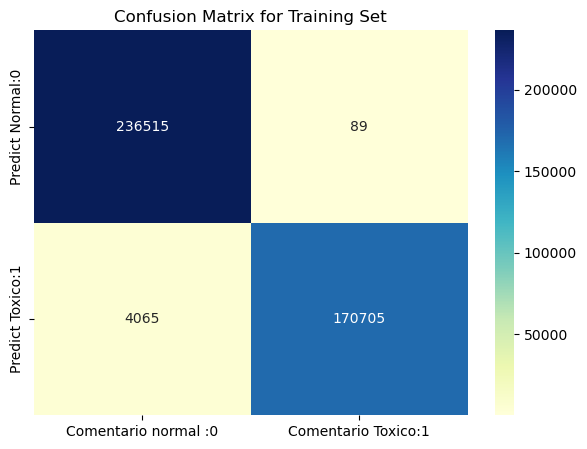

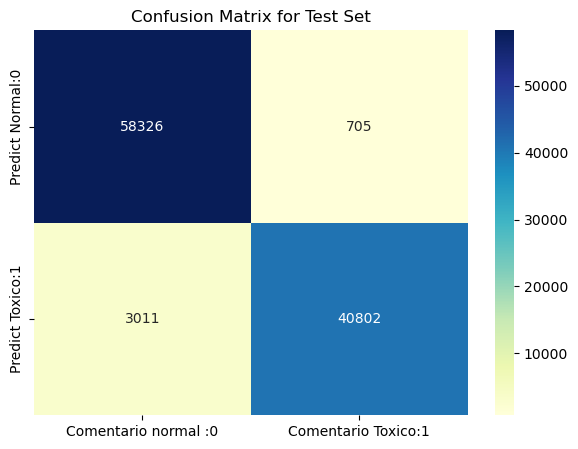

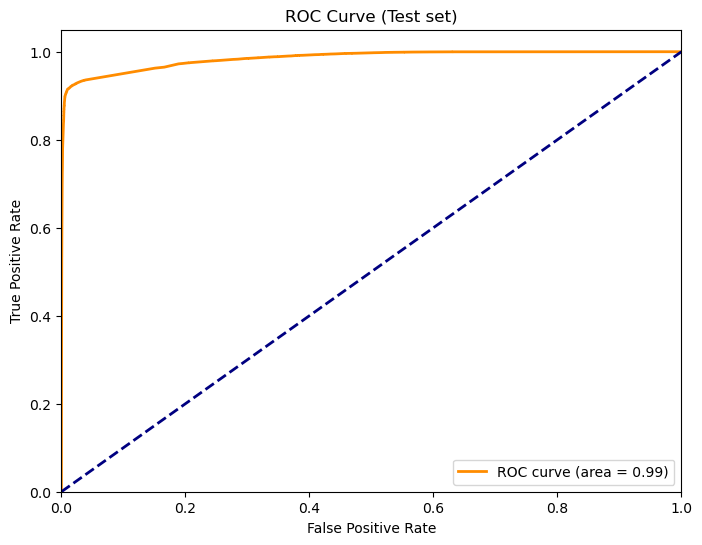

In [190]:
y_pred_train = model.predict(X_train_tfidf)
y_pred_test = model.predict(X_test_tfidf)

# Calcular y mostrar la precisión para los conjuntos de entrenamiento y prueba
print("\nTraining Accuracy score:", accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:", accuracy_score(y_test, y_pred_test))

# informe de clasificación train
print("\nClassification Report (train set):")
print(classification_report(y_train, y_pred_train, target_names=['Normal', 'Toxico']))

#  informe de clasificación test
print("\nClassification Report (Test set):")
print(classification_report(y_test, y_pred_test, target_names=['Normal', 'Toxico']))

# Matriz de confusión train
cm_train = confusion_matrix(y_train, y_pred_train)
cm_train_matrix = pd.DataFrame(data=cm_train,  columns=['Comentario normal :0', 'Comentario Toxico:1'], 
                              index=['Predict Normal:0', 'Predict Toxico:1'])

plt.figure(figsize=(7,5))
sns.heatmap(cm_train_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix for Training Set')
plt.show()

# Matriz de confusión test
cm_test = confusion_matrix(y_test, y_pred_test)
cm_test_matrix = pd.DataFrame(data=cm_test, columns=['Comentario normal :0', 'Comentario Toxico:1'], 
                              index=['Predict Normal:0', 'Predict Toxico:1'])

plt.figure(figsize=(7,5))
sns.heatmap(cm_test_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix for Test Set')
plt.show()


# se obtienen puntuaciones de las probabilidades para el conjunto de entrenamiento y prueba
y_scores_train = lgbm.predict_proba(X_train_tfidf)[:, 1]
y_scores_test = lgbm.predict_proba(X_test_tfidf)[:, 1]

# Dibuja la curva ROC para el conjunto de prueba
plot_roc_curve(y_test, y_scores_test, 'ROC Curve (Test set)')

model_filename = 'lgbm_optimo.pickle'
with open(model_filename, 'wb') as model_file:
    pickle.dump(model, model_file)

# Prueba con comentarios Nuevos

### Preprocesamiento

Con el fin de probar nuevos comentarios y probar nuestro modelo se debe cargar el preprocesamiento que se debe aplicar 

In [197]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nlp = spacy.load('es_core_news_sm')

with open('tfidf_vectorizer.pickle', 'rb') as file:
    tfidf_vectorizer_loaded = pickle.load(file)

with open('lgbm_optimo.pickle', 'rb') as model_file:
    lgbm_model = pickle.load(model_file)
    
def remove_accents(input_str):
    # Mapeo de vocales acentuadas a sus equivalentes sin acento
    replacements = {
        'á': 'a',
        'é': 'e',
        'í': 'i',
        'ó': 'o',
        'ú': 'u',
        'Á': 'A',
        'É': 'E',
        'Í': 'I',
        'Ó': 'O',
        'Ú': 'U'
    }
    # Reemplaza las vocales acentuadas en el texto
    for accented_char, unaccented_char in replacements.items():
        input_str = input_str.replace(accented_char, unaccented_char)
    return input_str

def get_all_string(sentences):
    sentence = ''
    for words in sentences:
        sentence += words.replace('\n', ' ')
    # Limpieza del texto y quitar acentos
    sentence = remove_accents(sentence)
    sentence = re.sub('[^A-Za-z0-9 ñÑ]+', '', sentence)
    sentence = re.sub(r'http\S+', '', sentence)
    sentence = sentence.lower()
    return sentence

def get_word(sentence):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(sentence)

def remove_stopword(word_tokens):
    stopword_list = stopwords.words('spanish')  # Usar lista de stopwords en español
    filtered_tokens = []
    for word in word_tokens:
        if word not in stopword_list:
            filtered_tokens.append(word)
    return filtered_tokens 

def lemmatize_words_spacy(filtered_tokens):
    doc = nlp(" ".join(filtered_tokens))
    cleaned_tokens = [token.lemma_ for token in doc]
    return cleaned_tokens

def preprocess(text):
    # Primero, limpia el texto
    cleaned_text = get_all_string([text])
    # Segundo, tokeniza el texto
    words = get_word(cleaned_text)
    # Tercero, elimina las stopwords
    filtered_tokens = remove_stopword(words)
    cleaned_tokens = lemmatize_words_spacy(filtered_tokens)
    # Une los tokens limpios en una cadena para almacenamiento en DataFrame
    return ' '.join(cleaned_tokens)

my_stopwords = set([
    "una", "un", "él", "el", "los", "esto", "estos", "es", "en", "lo", "de", "y", "a", "que", 
    "la", "las", "para", "con", "no", "se", "del", "al", "como", "más", "pero", "sus", "le", 
    "ya", "o", "este", "por", "qué", "nos", "ni", "entre", "cuando", "también", "sino", "sobre", 
    "este", "ya", "si", "su", "aquí", "allá", "hay", "fue", "era", "son", "han", "había", "tengo", 
    "tienes", "tenemos", "tienen", "tenga", "tengas", "tenemos", "tengan", "mi", "mis", "tu", "tus", 
    "nuestro", "nuestra", "nuestros", "nuestras", "vuestro", "vuestra", "vuestros", "vuestras", 
    "este", "estas", "ese", "esos", "esa", "esas", "aquel", "aquellos", "aquella", "aquellas", 
    "mío", "mía", "míos", "mías", "tuyo", "tuya", "tuyos", "tuyas", "suyo", "suya", "suyos", "suyas",
    "nada", "todo", "todos", "todas", "mucho", "muchos", "mucha", "muchas", "poco", "pocos", "poca", 
    "pocas", "alguno", "alguna", "algunos", "algunas", "ninguno", "ninguna", "ningunos", "ningunas",
    "cualquier", "cualquiera", "cualquieras", "cada", "cierto", "ciertos", "cierta", "ciertas",
    "varios", "varias", "tantos", "tantas", "demasiado", "demasiados", "demasiada", "demasiadas",
    "bastante", "bastantes", "mismo", "misma", "mismos", "mismas", "tan", "tanto", "tanta", "tantos", "tantas",
    "algo", "alguien", "quien", "quienes", "cuyo", "cuya", "cuyos", "cuyas",
    "dónde", "cuándo", "cómo", "porqué", "por qué", "cuál", "cuáles", "quién", "quiénes",
    "dónde", "adónde", "de dónde", "hacia dónde","mas","más"
])

def clean_message(row, stopwords):
    if pd.notna(row):  # Verifica que la fila no sea NaN
        # Convierte la fila a string y tokeniza el mensaje
        tokens = word_tokenize(str(row))
        # Elimina palabras que solo tienen un carácter y no están en el conjunto de stopwords
        tokens = [word for word in tokens if len(word) > 1 or word in stopwords]
        # Elimina stopwords
        tokens = [word for word in tokens if word not in stopwords]
        # Une los tokens para formar el string limpio
        return ' '.join(tokens)
    return ""  # Retorna un string vacío si la fila es NaN



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\O004607\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\O004607\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\O004607\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Comentarios prueba

In [198]:
def predict_comment_toxicity(comment):
    # Preprocesamiento y limpieza del comentario
    preprocessed_comment = preprocess(comment)
    cleaned_comment = clean_message(preprocessed_comment, my_stopwords)
    # Vectorización del comentario limpio
    vectorized_comment = tfidf_vectorizer_loaded.transform([cleaned_comment])
    # Realizar la predicción
    prediction_probability = lgbm_model.predict_proba(vectorized_comment)[:,1]
    prediction = (prediction_probability >= 0.4753804765803507).astype(int)
    
    return prediction[0], prediction_probability[0]

### Comentarios normales

In [213]:
comment = "Recibí el producto a tiempo y en perfecto estado, muchas gracias por la eficiencia."
prediction, probability = predict_comment_toxicity(comment)
print(f"Probabilidad de ser tóxico: {probability}")
print(f"Clasificación (1=Tóxico, 0=No Tóxico): {prediction}")

Probabilidad de ser tóxico: 0.002003198058491928
Clasificación (1=Tóxico, 0=No Tóxico): 0


In [214]:
comment = "¿Alguien ha probado este producto? Estoy interesado en sus opiniones antes de comprarlo."
prediction, probability = predict_comment_toxicity(comment)
print(f"Probabilidad de ser tóxico: {probability}")
print(f"Clasificación (1=Tóxico, 0=No Tóxico): {prediction}")

Probabilidad de ser tóxico: 0.0009147315378091669
Clasificación (1=Tóxico, 0=No Tóxico): 0


In [215]:
comment = "La calidad de este producto superó mis expectativas, definitivamente lo recomendaría."
prediction, probability = predict_comment_toxicity(comment)
print(f"Probabilidad de ser tóxico: {probability}")
print(f"Clasificación (1=Tóxico, 0=No Tóxico): {prediction}")

Probabilidad de ser tóxico: 0.010906893480371431
Clasificación (1=Tóxico, 0=No Tóxico): 0


In [216]:
comment = "Tengo una pregunta sobre la garantía del producto, ¿podrían proporcionarme más información?"
prediction, probability = predict_comment_toxicity(comment)
print(f"Probabilidad de ser tóxico: {probability}")
print(f"Clasificación (1=Tóxico, 0=No Tóxico): {prediction}")

Probabilidad de ser tóxico: 0.00023698838782914157
Clasificación (1=Tóxico, 0=No Tóxico): 0


In [217]:
comment = "Estoy muy satisfecho con la compra. El servicio al cliente fue excelente."
prediction, probability = predict_comment_toxicity(comment)
print(f"Probabilidad de ser tóxico: {probability}")
print(f"Clasificación (1=Tóxico, 0=No Tóxico): {prediction}")

Probabilidad de ser tóxico: 0.009979601466245028
Clasificación (1=Tóxico, 0=No Tóxico): 0


### Comentarios Toxicos

In [224]:
comment = "Este producto es una  mierda"
prediction, probability = predict_comment_toxicity(comment)
print(f"Probabilidad de ser tóxico: {probability}")
print(f"Clasificación (1=Tóxico, 0=No Tóxico): {prediction}")

Probabilidad de ser tóxico: 0.8120455306304064
Clasificación (1=Tóxico, 0=No Tóxico): 1


In [219]:
comment = "El vendedor es un estafador, el producto no cumple con lo prometido."
prediction, probability = predict_comment_toxicity(comment)
print(f"Probabilidad de ser tóxico: {probability}")
print(f"Clasificación (1=Tóxico, 0=No Tóxico): {prediction}")

Probabilidad de ser tóxico: 0.9932347068136964
Clasificación (1=Tóxico, 0=No Tóxico): 1


In [225]:
comment = "¡Pésimo servicio! Me arrepiento."
prediction, probability = predict_comment_toxicity(comment)
print(f"Probabilidad de ser tóxico: {probability}")
print(f"Clasificación (1=Tóxico, 0=No Tóxico): {prediction}")

Probabilidad de ser tóxico: 0.9980208222550989
Clasificación (1=Tóxico, 0=No Tóxico): 1


In [229]:
comment = "Absolutamente decepcionado con este trasto. El vendedor debe ser un completo imbécil para pensar que esto vale algo."
prediction, probability = predict_comment_toxicity(comment)
print(f"Probabilidad de ser tóxico: {probability}")
print(f"Clasificación (1=Tóxico, 0=No Tóxico): {prediction}")

Probabilidad de ser tóxico: 0.9917159029605385
Clasificación (1=Tóxico, 0=No Tóxico): 1


In [231]:
comment = "El servicio al cliente es una mierda, igual que su producto. No esperes ayuda de estos incompetentes."
prediction, probability = predict_comment_toxicity(comment)
print(f"Probabilidad de ser tóxico: {probability}")
print(f"Clasificación (1=Tóxico, 0=No Tóxico): {prediction}")

Probabilidad de ser tóxico: 0.6077795995892987
Clasificación (1=Tóxico, 0=No Tóxico): 1


### Potenciales problemas

* El diccionario de stopwords en español utilizado resultó insuficiente, requiriendo la adición manual de términos para su optimización. A pesar de estos ajustes, es posible que algunas stopwords aún no se hayan identificado adecuadamente, lo que podría afectar la precisión del análisis.

* Los wordclouds, gráficos de barras, y análisis de bigramas y trigramas revelaron que ciertas palabras no fueron correctamente lematizadas. Esto sugiere la necesidad de desarrollar un diccionario de lematización personalizado para mejorar el tratamiento de estas palabras específicas. 

* El preprocesamiento de datos y entrenamiento de modelos resultó ser lento debido a limitaciones en la capacidad del equipo local. Para manejar mayores volúmenes de datos y entrenar modelos más complejos, sería conveniente utilizar servicios de computación en la nube.


### Condiciones ideales:
    
Para un rendimiento óptimo, se recomienda procesar los datos en lotes diarios y realizar análisis en tiempo real mediante streaming. Esta configuración ideal permitiría que el sistema evalúe continuamente las frases a medida que se reciben, aprovechando el modelo y el vectorizador previamente almacenados. Las pruebas preliminares han demostrado la capacidad del sistema para identificar comentarios efectivamente al ingresarlos directamente, lo que valida la eficacia del enfoque propuesto en condiciones ideales de operación.

### Proximos pasos:

* Para abordar las áreas de mejora identificadas, se propone adaptar nuevas palabras y optimizar los diccionarios de stopwords y lematización. Este proceso implicará una revisión detallada para identificar aquellas palabras que, a pesar de ser significativas, no han sido adecuadamente procesadas o excluidas. Para asi sacar mejor provecho del TD-IDF

* Se podría  realizar pruebas utilizando **FastText**, un modelo de aprendizaje automático diseñado para la clasificación de texto y la representación de palabras. FastText sobresale por su capacidad de considerar subpalabras o n-gramas de caracteres dentro de las palabras, lo que le permite captar la estructura interna de estas y manejar eficientemente palabras desconocidas. Esta característica resulta en un modelo que no solo es eficaz en el reconocimiento y clasificación del texto, sino también en el manejo de un amplio vocabulario, incluyendo términos no vistos durante el entrenamiento. 

Se ha desarrollado un notebook que presenta una aproximación al uso de Fasttext, este se encuentra en otro notebook debido a que fue desarrolado en colab por un problema de compatibilidad con mi local, resaltando su eficiencia y simplicidad en la creación de modelos de clasificación de texto. Los resultados obtenidos muestran métricas sólidas, destacando la capacidad del modelo para manejar comentarios nuevos, tanto normales como tóxicos, con precisión. Para más detalles, se invita a revisar el archivo denominado **"Romero_david_Fasttext.ipynb".**

## Casos de uso

**Moderación Automática de Comentarios y Reseñas:** Mejorar la confianza en la plataforma al asegurar que todas las reseñas y comentarios en las páginas de productos sean libres de lenguaje ofensivo, contribuyendo a una experiencia de compra positiva y constructiva para los usuarios.

**Filtrado de Descripciones de Productos:** Prevenir la publicación de descripciones de productos que contengan lenguaje inapropiado o discriminatorio, manteniendo altos estándares de calidad en los listados y asegurando que el contenido sea adecuado para todos los públicos.

**Seguridad en la Comunicación entre Compradores y Vendedores:** Proteger a los usuarios al detectar y bloquear el envío de mensajes ofensivos o inapropiados a través de la mensajería interna de la plataforma, promoviendo interacciones seguras y respetuosas entre compradores y vendedores.

**Prevención de Búsquedas Inapropiadas:** El sistema puede ser utilizado para detectar y prevenir que búsquedas con términos ofensivos generen resultados, guiando a los usuarios hacia contenido apropiado y evitando la propagación de material inapropiado o discriminatorio.

